# Generative Models

## GANs & VAE

### HW4

In this notebook, we are going to implement Variational AutoEncoder (VAE) and Generative Adversarial Network (GAN) on the MNIST dataset. VAEs learn a latent variable model from input data. They sample from this distribution and decode it to generate new data. GANs uses a generator to make images based on a prior distribution.


+ Complete the `TODO` parts in the code accordingly.

In [1]:
from torch.utils.data import DataLoader, random_split
from torch import optim
from tqdm.notebook import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [2]:

from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/DL/HW2/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset

We will be using MNIST dataset which consists of 60000 data. We split them into train and validation sets, each having 50000 and 10000 data respectively.

In [3]:
transformation = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

train_data, valid_data = random_split(mnist_data, [50000, 10000])

In [5]:
num_threads = 4
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_threads)
val_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=num_threads)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# VAE

Variational Autoencoders (VAEs) are a class of generative models that aim to learn the probability distribution of a given dataset in order to generate new data points that resemble the original data. They use and encoder that embeds each data to a smaller latent space and a decoder that tries to generate the original image, given this latent space.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/VAE_Basic.png/425px-VAE_Basic.png)
---


In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        ##########################################################
        # TODO
        # Define your variational encoder layers.
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)
        ##########################################################


    def forward(self, x):

        ##########################################################
        # TODO
        # Convert input `x` to mean and log variance of latent
        # space which is then used to sample data for the decoder.
        h = F.relu(self.fc1(x))
        z_mean = self.fc_mean(h)
        z_log_var = self.fc_log_var(h)
        ##########################################################

        return z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        ##############################
        # TODO
        # Define your decoder layers.
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        ##############################

    def forward(self, z):
        ########################################
        # TODO
        # Decode the latent vector `z` to images.
        h = F.relu(self.fc1(z))
        reconstruction = torch.sigmoid(self.fc2(h)) # Use sigmoid for pixel values between 0 and 1
        ########################################

        return reconstruction

In [7]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        ##########################################################
        # TODO
        # Using the encoder and decoder you have defined, encode the
        # image to the latent space and then reconstruct it.
        # Use the reparameterization trick to ensure gradient flow.
        z_mean, z_log_var = self.encoder(x)

        # Reparameterization trick
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std)
        z = z_mean + eps * std

        image_recon = self.decoder(z)
        ##########################################################

        return image_recon, z_mean, z_log_var

In [8]:
def reconstruct_images(vae, images):
    images = images.view(-1, 784)
    with torch.no_grad():
        recon_images, _, _ = vae(images)
    return recon_images.view(-1, 1, 28, 28)

def plot_images(original, reconstructed, n=4):
    fig, axes = plt.subplots(2, n, figsize=(10, 4))
    for i in range(n):
        axes[0, i].imshow(original[i].squeeze().cpu().numpy(), cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].squeeze().cpu().numpy(), cmap='gray')
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')
    plt.show()

In [9]:
def loss_function(x, x_hat, mean, log_var):
    """Elbo loss function."""
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction="sum")
    kld = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + kld

def train_vae(dataloader, val_loader, latent_dim, hidden_dim, input_dim, learning_rate=1e-4, num_epochs=100):
    ###############################################
    # TODO
    # Define the loss fc, optimizer and VAE model.
    ###############################################
    model = VAE(input_dim, hidden_dim, latent_dim).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    sample_images, _ = next(iter(val_loader))
    sample_images = sample_images.to(DEVICE)

    recon_images = []

    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        print(f'Epoch {epoch+1}: ')
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, data in pbar:

                ###############################################
                # TODO
                # Calculate the loss.
                # (optional) Use the KL divergence loss to normalize the
                # output distribution of decoder.
                images, _ = data
                images = images.view(-1, input_dim).to(DEVICE)

                # Forward pass
                recon_images_batch, z_mean, z_log_var = model(images)

                # Calculate loss
                loss = loss_function(images, recon_images_batch, z_mean, z_log_var)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                train_loss += loss.item()
                optimizer.step()
                ###############################################

            print('Loss: {:.4f}'.format(train_loss / len(dataloader.dataset)))

        # TODO
        # Reconstruct `sample_images` and plot first 4 images after each epoch
        # This is used to visualize the progress
        with torch.no_grad():
          model.eval()
          recon_images = reconstruct_images(model, sample_images)
          plot_images(sample_images, recon_images)

          val_loss = 0
          with tqdm(enumerate(val_loader), total=len(val_loader)) as pbar:
            for i, data in pbar:
                x = data[0]
                x = x.view(-1, input_dim)
                x = x.to(DEVICE)
                x_hat, mean, log_var = model(x)
                loss = loss_function(x, x_hat, mean, log_var)
                val_loss += loss.item()

            print('Val Loss: {:.4f}'.format(val_loss / len(val_loader.dataset)))
            val_losses.append(val_loss / len(val_loader.dataset))


        # Sample From Latent Space
        if epoch % 10 == 0:
            with torch.no_grad():
                x = torch.randn(8, latent_dim).to(DEVICE)
                samples = model.decoder(x).cpu()
                samples = samples.view(8, 1, 28, 28)
                grid_img = torchvision.utils.make_grid(samples, nrow=4, padding=2, normalize=True)
                plt.figure(figsize=(15, 15))
                plt.imshow(grid_img.permute(1, 2, 0))
                plt.axis('off')
                plt.show()

    return model, val_losses

Epoch 1: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 250.6307


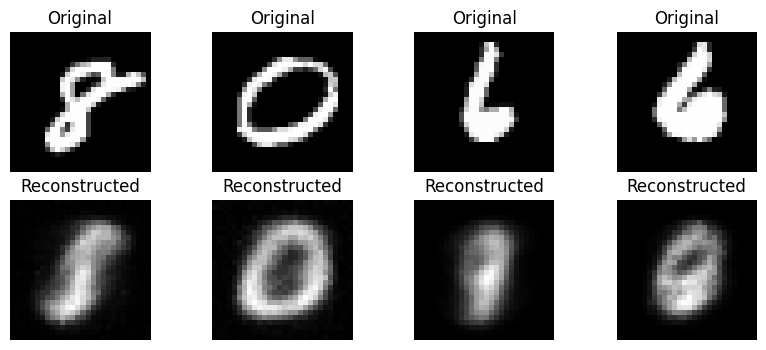

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 190.1334


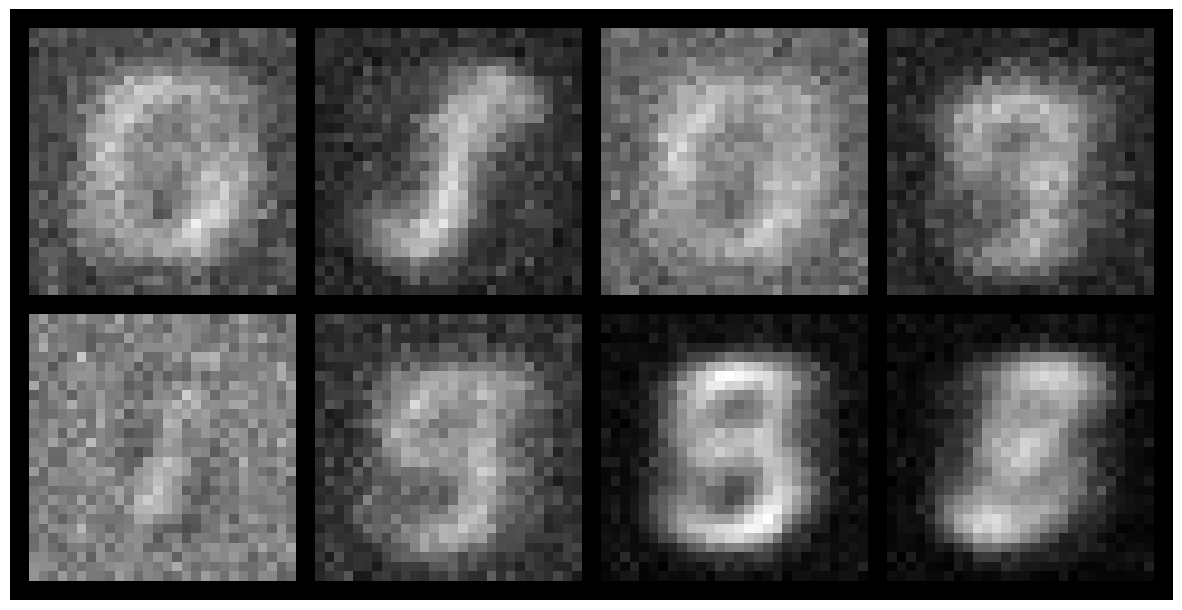

Epoch 2: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 171.4291


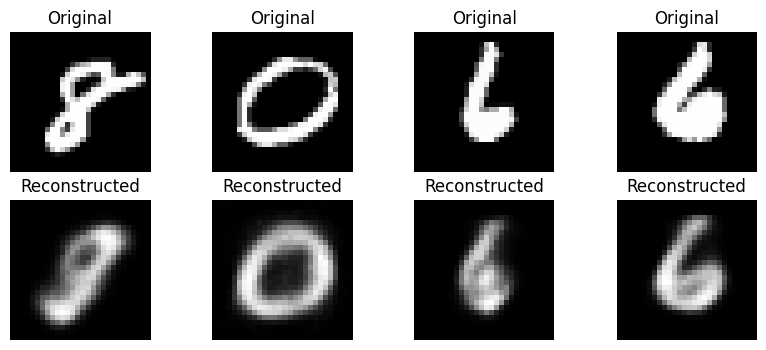

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 160.9249
Epoch 3: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 153.4755


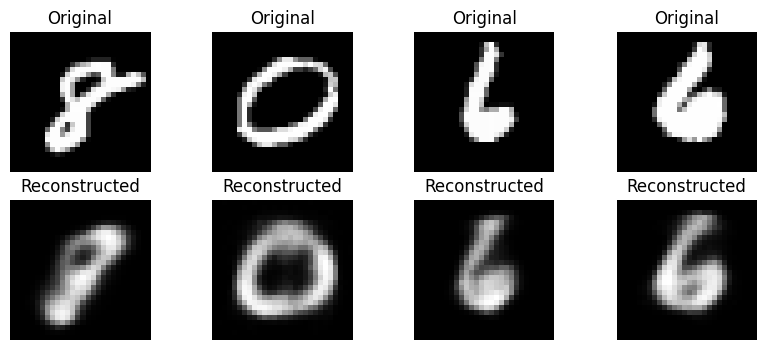

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 149.0064
Epoch 4: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 144.3178


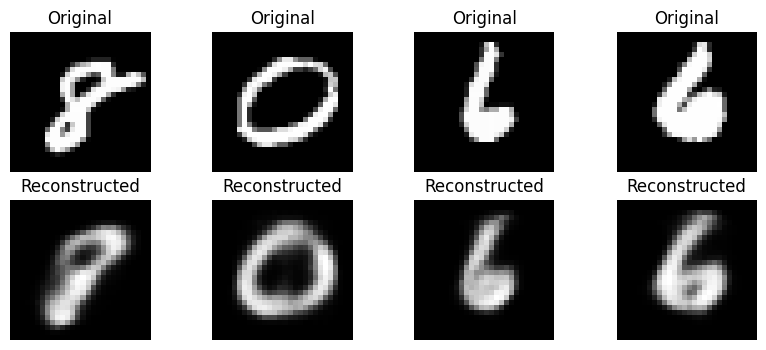

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 141.5741
Epoch 5: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 138.0435


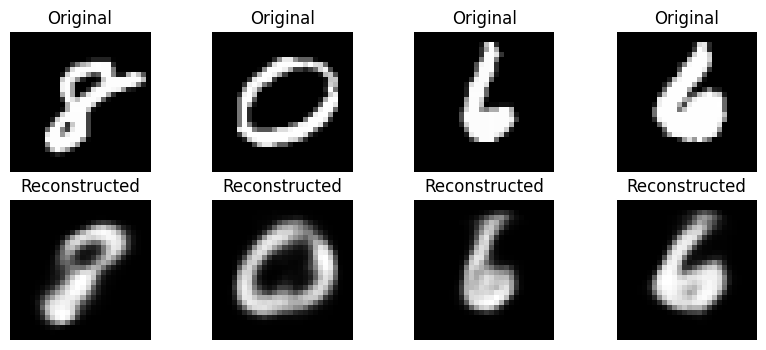

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 136.5758
Epoch 6: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 133.9970


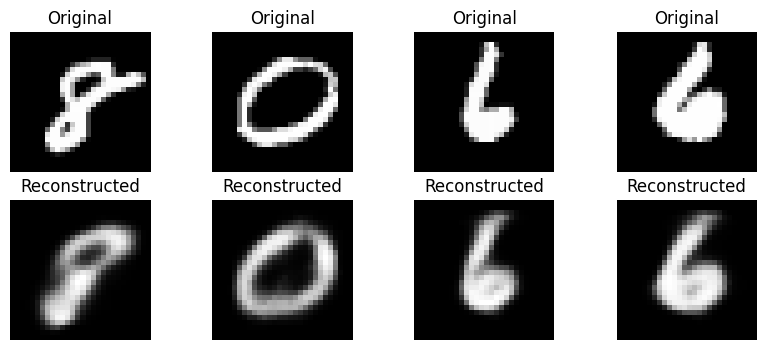

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 133.1497
Epoch 7: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 131.1294


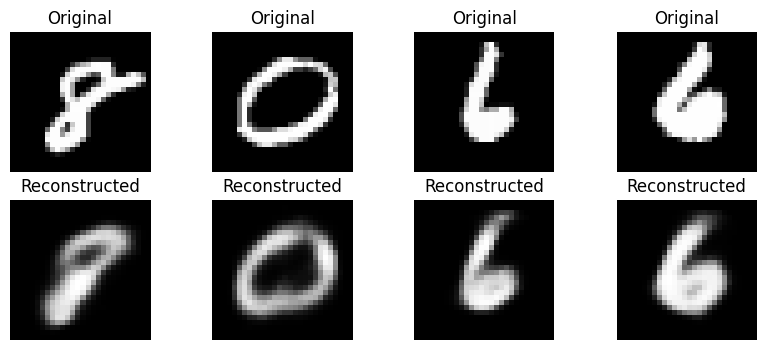

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 130.6880
Epoch 8: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 128.9789


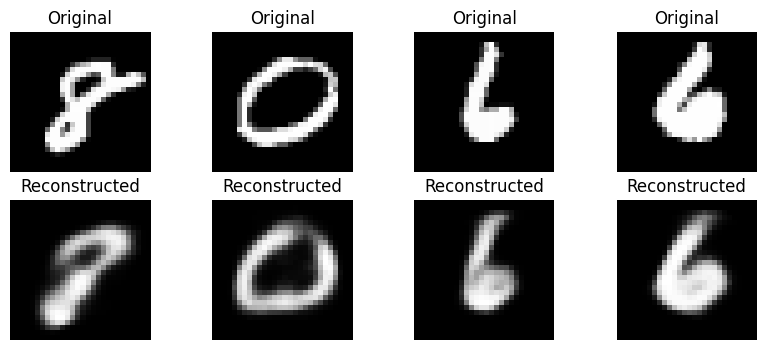

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 128.8867
Epoch 9: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 127.3199


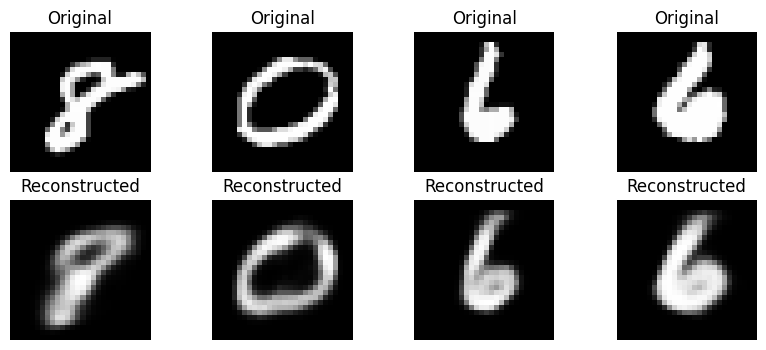

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 127.3511
Epoch 10: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 125.9203


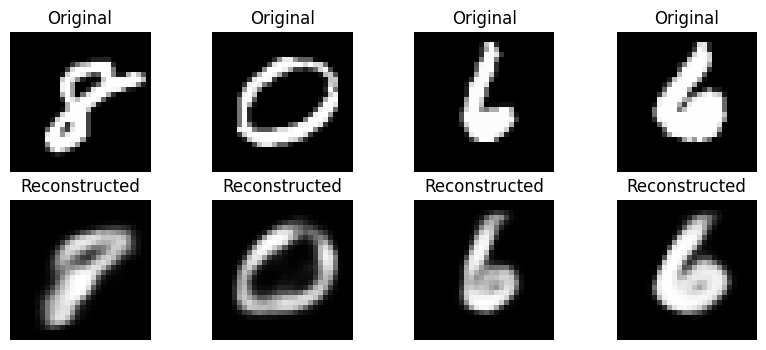

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 126.1554
Epoch 11: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 124.7762


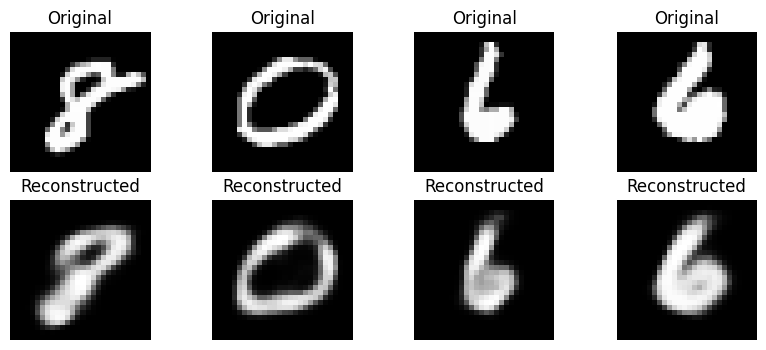

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 125.0297


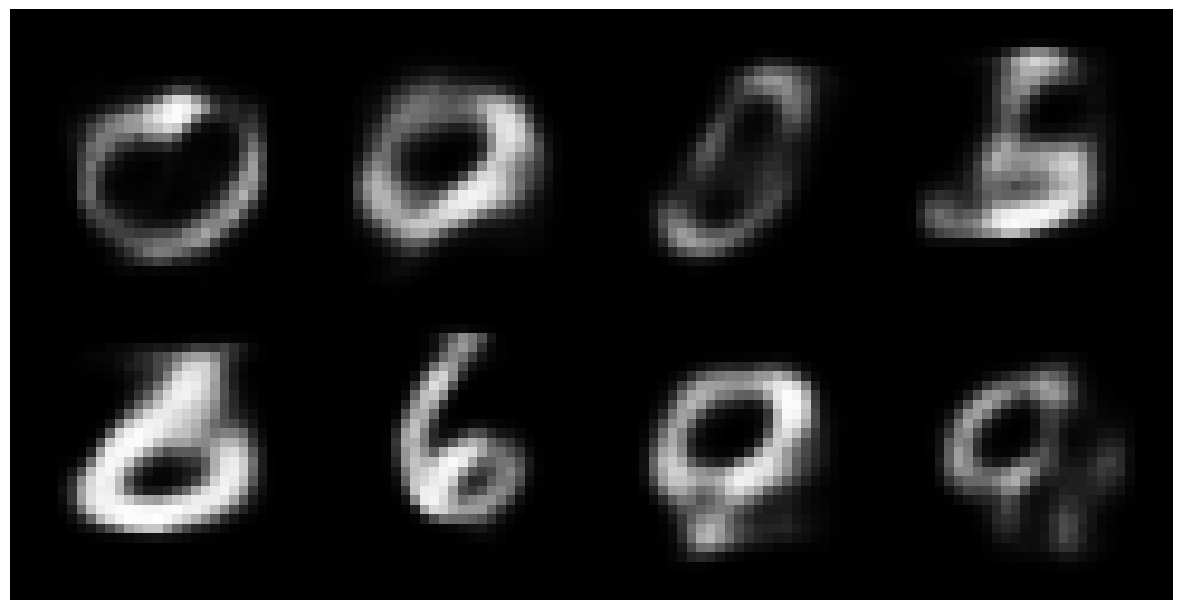

Epoch 12: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 123.7503


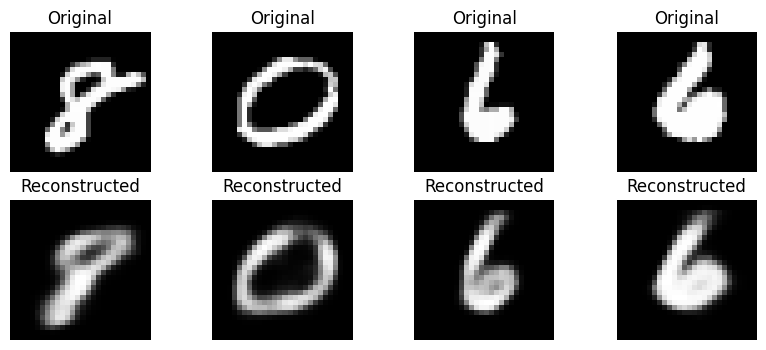

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 124.1333
Epoch 13: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 122.8921


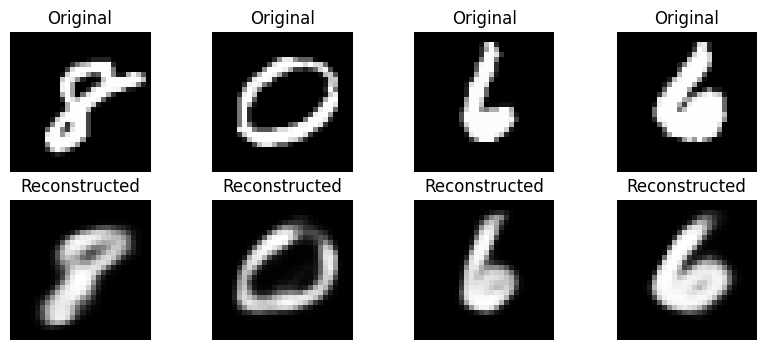

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 123.2535
Epoch 14: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 122.1125


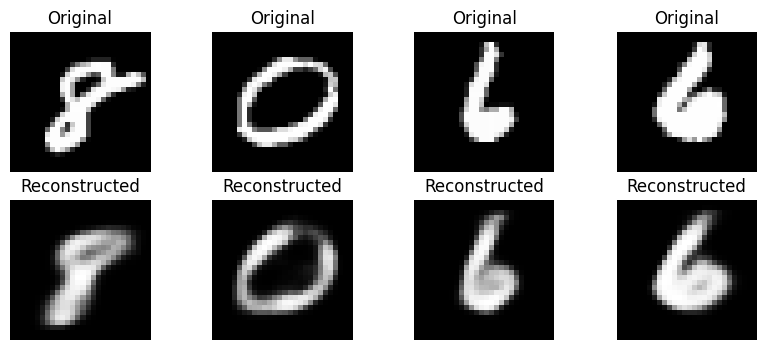

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 122.5457
Epoch 15: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 121.4798


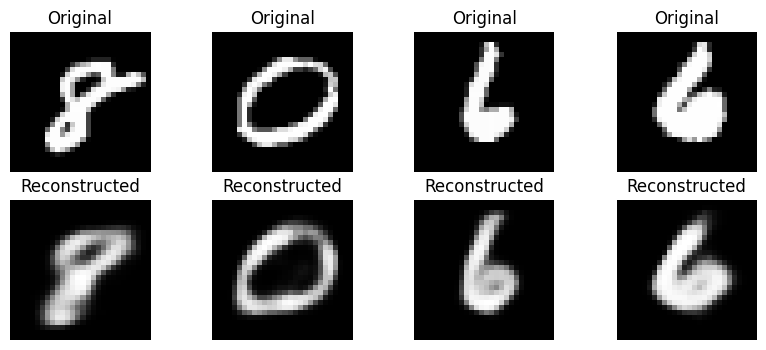

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 121.8652
Epoch 16: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 120.8329


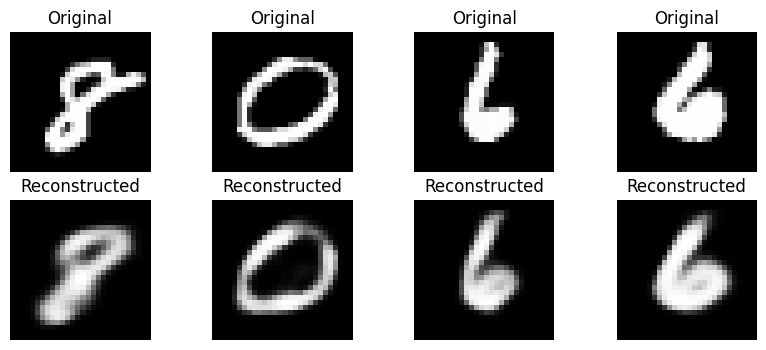

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 121.3255
Epoch 17: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 120.2531


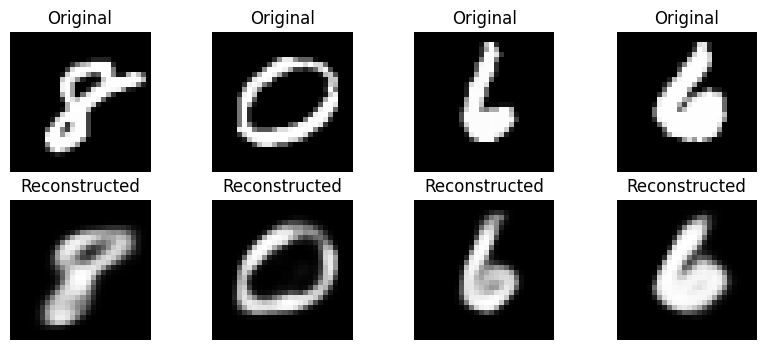

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 120.9495
Epoch 18: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 119.7730


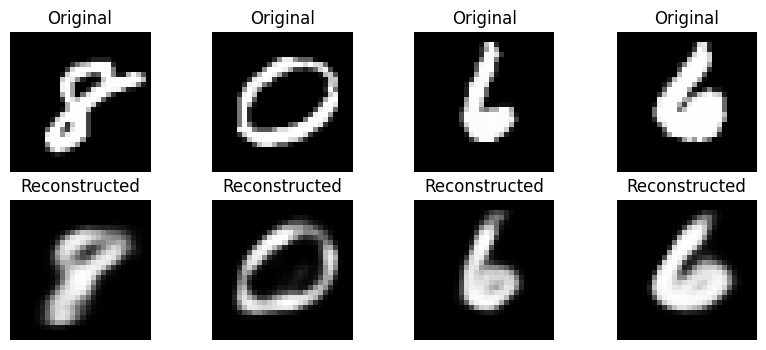

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 120.3818
Epoch 19: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 119.2914


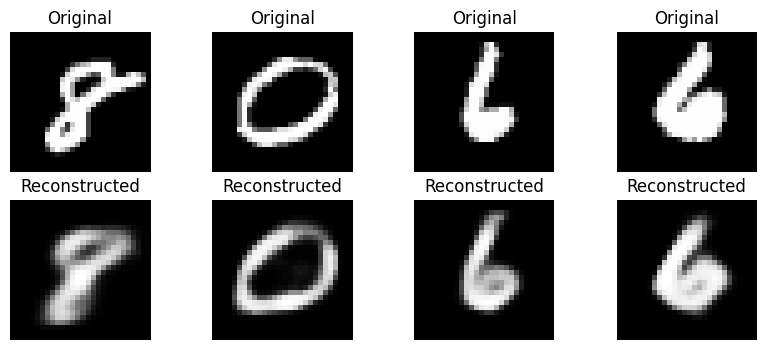

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 119.9040
Epoch 20: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 118.8836


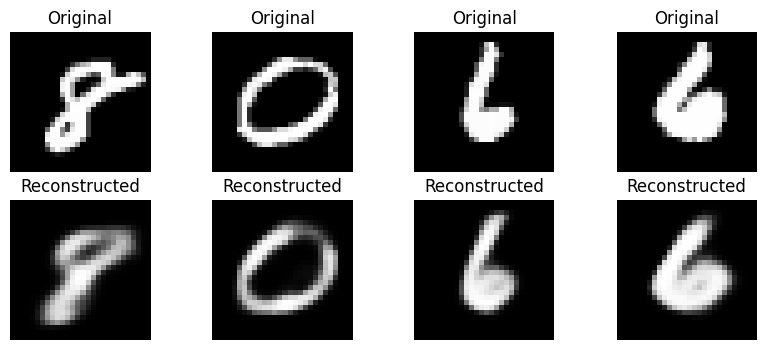

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 119.5629
Epoch 21: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 118.4830


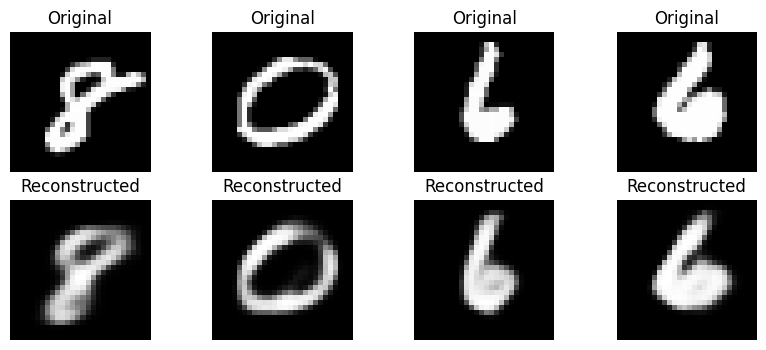

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 119.2257


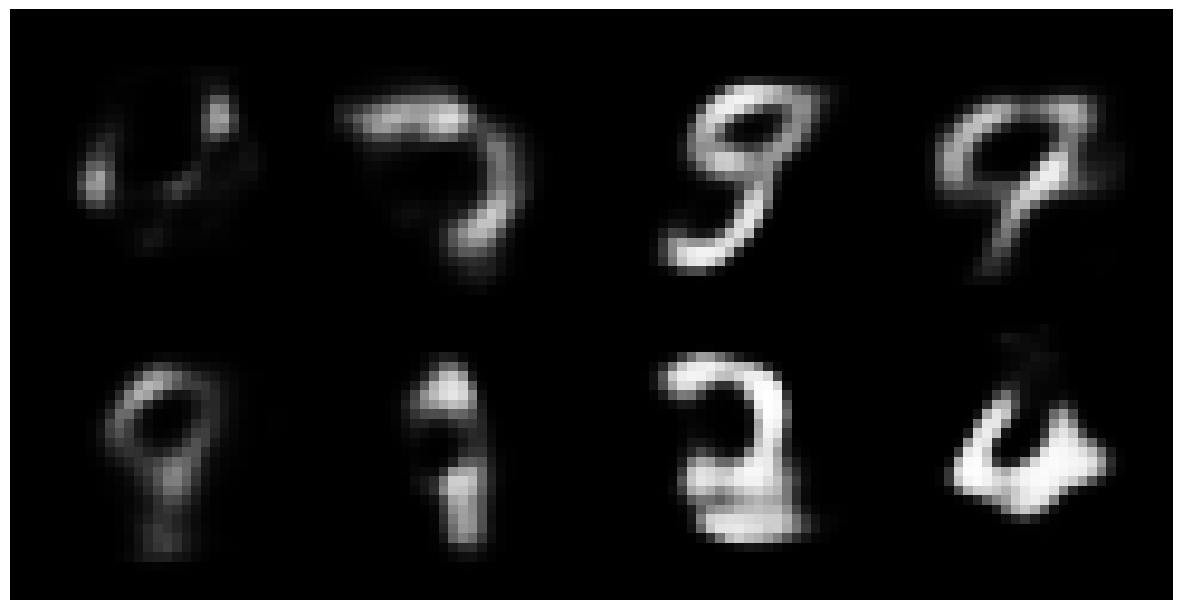

Epoch 22: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 118.1274


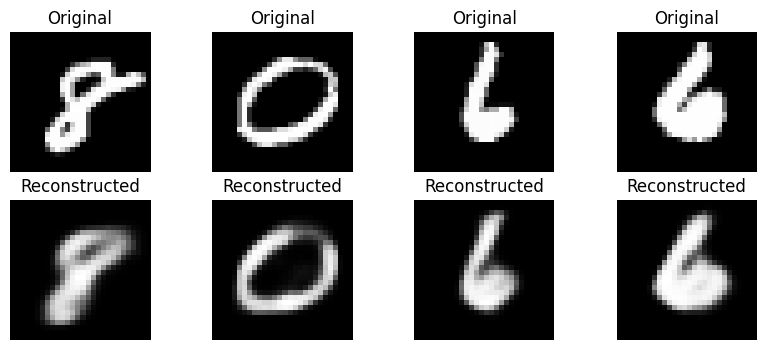

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 118.7742
Epoch 23: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 117.8135


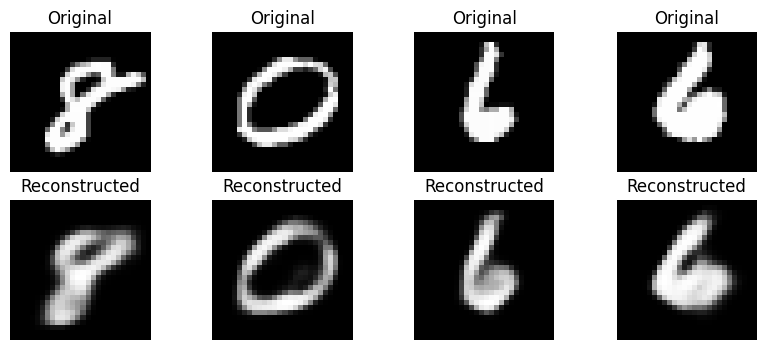

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 118.4782
Epoch 24: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 117.4845


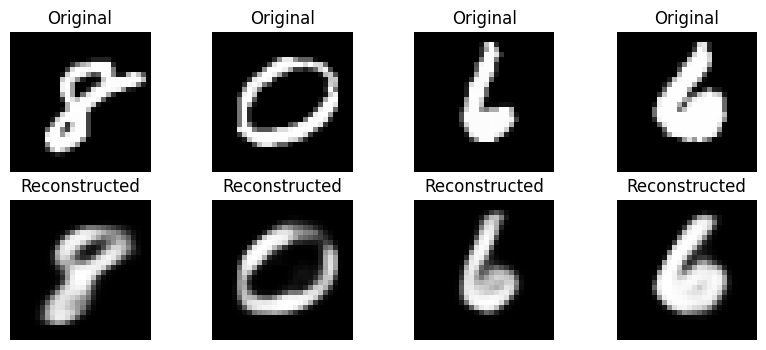

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 118.1812
Epoch 25: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 117.2036


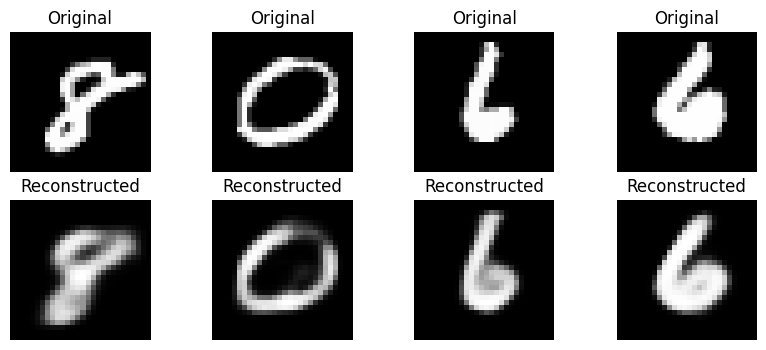

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 117.9420
Epoch 26: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 116.9166


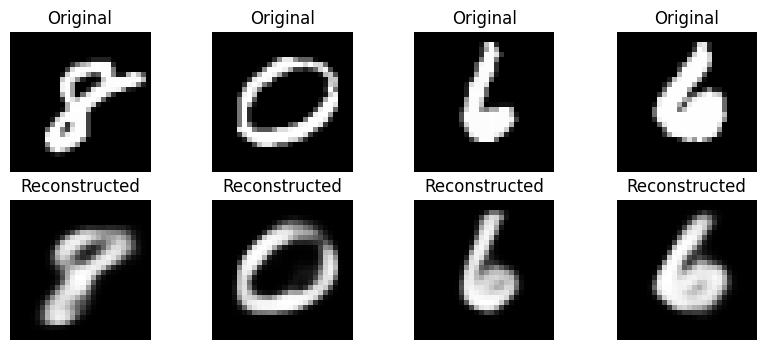

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 117.6838
Epoch 27: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 116.6712


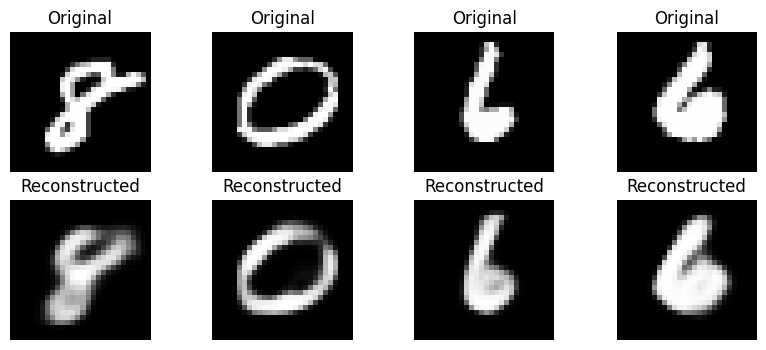

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 117.4505
Epoch 28: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 116.4301


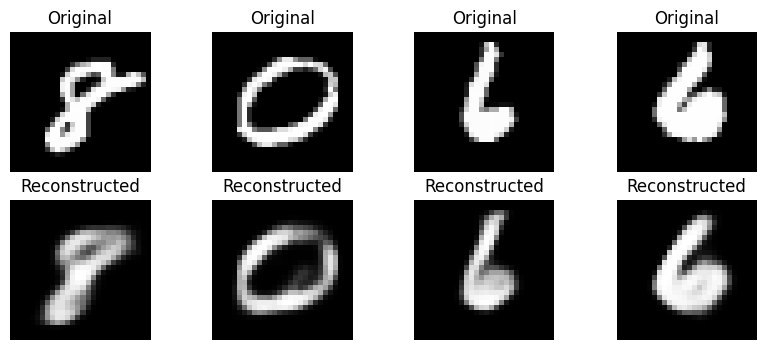

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 117.2485
Epoch 29: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 116.1919


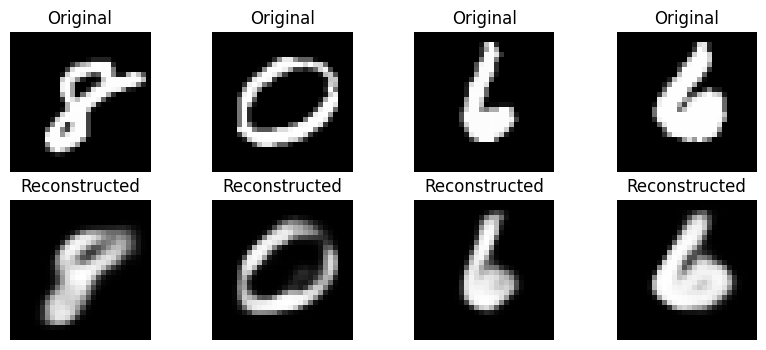

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 117.0117
Epoch 30: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 115.9517


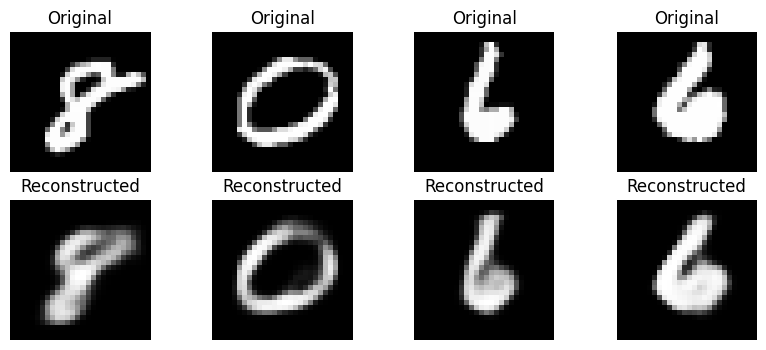

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 116.8335
Epoch 31: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 115.7676


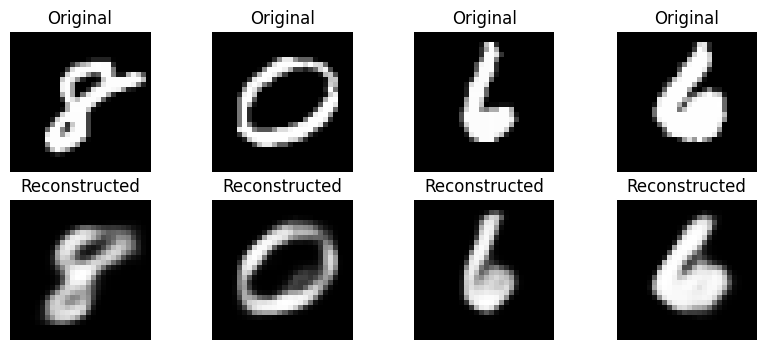

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 116.5645


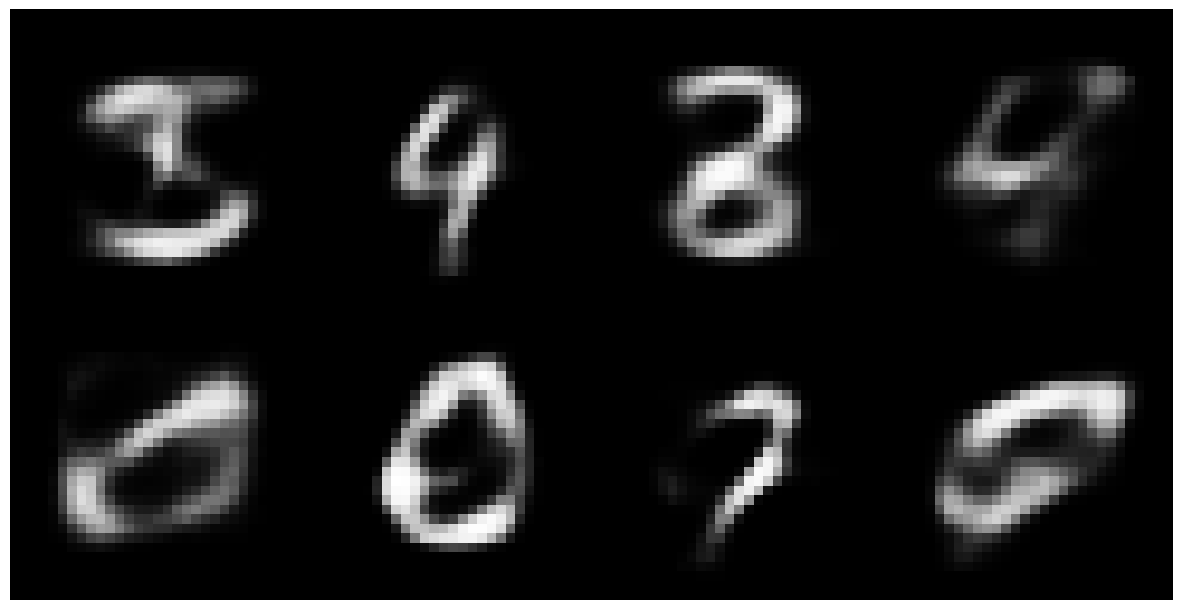

Epoch 32: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 115.6040


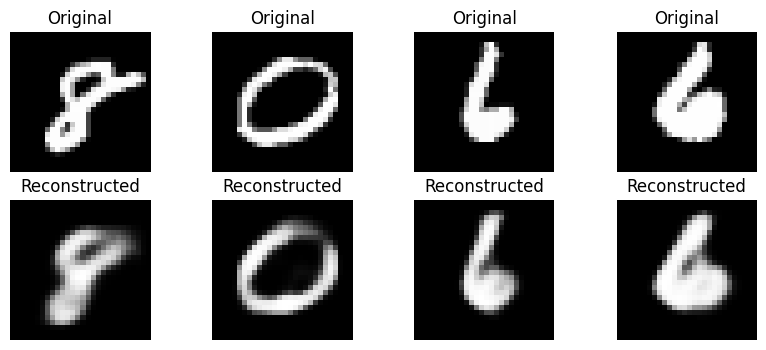

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 116.3165
Epoch 33: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 115.4132


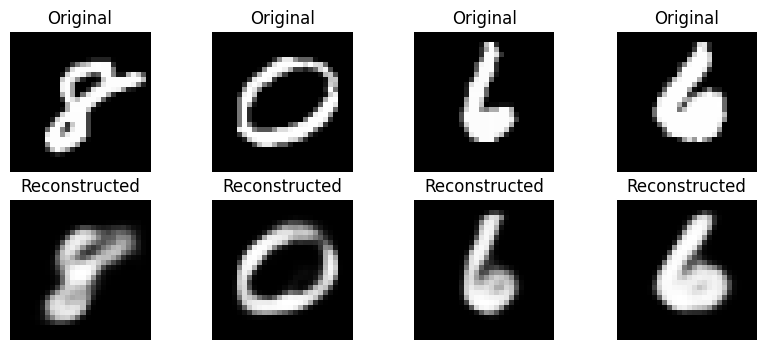

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 116.2340
Epoch 34: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 115.2208


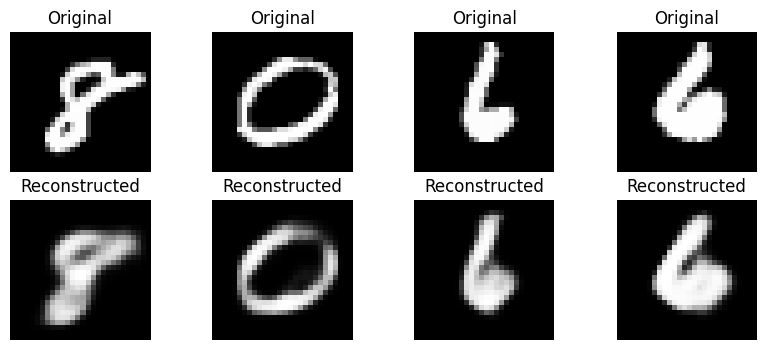

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 116.1429
Epoch 35: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 115.0459


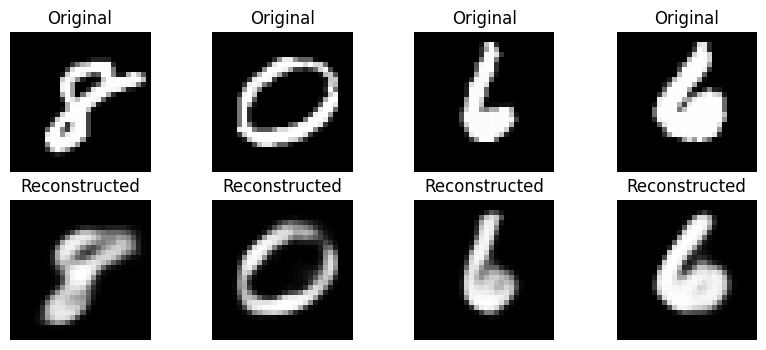

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 115.9130
Epoch 36: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 114.8717


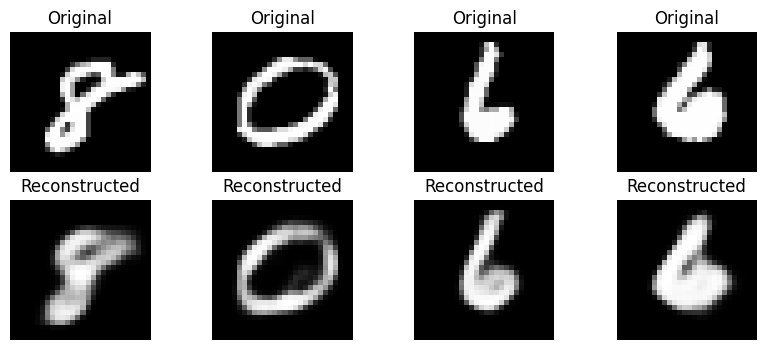

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 115.7304
Epoch 37: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 114.7020


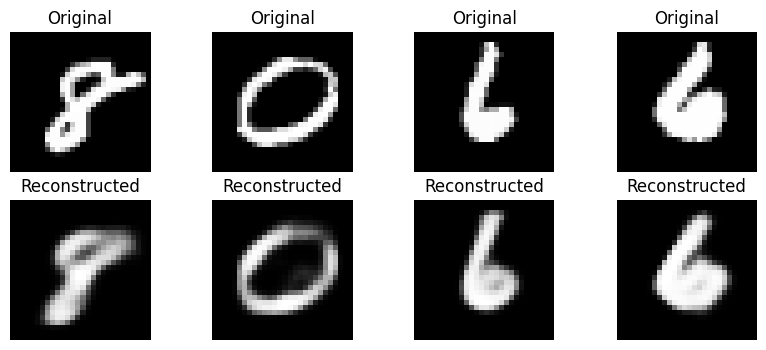

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 115.5887
Epoch 38: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 114.5514


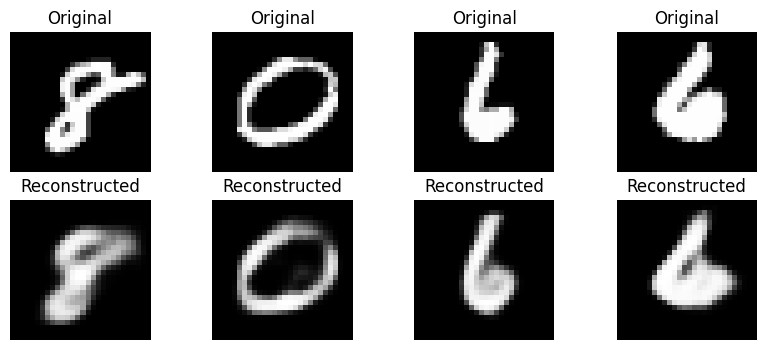

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 115.4597
Epoch 39: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 114.4119


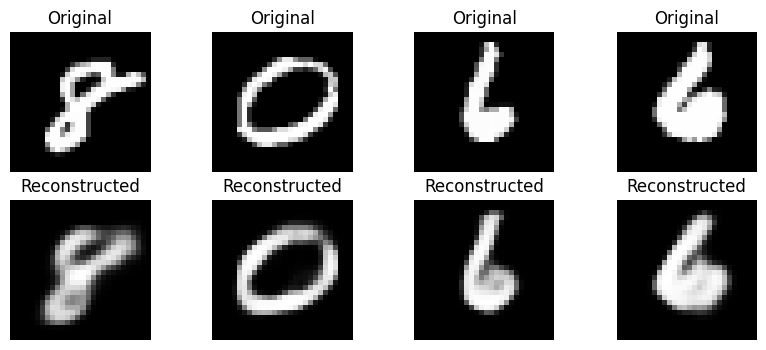

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 115.3038
Epoch 40: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 114.2707


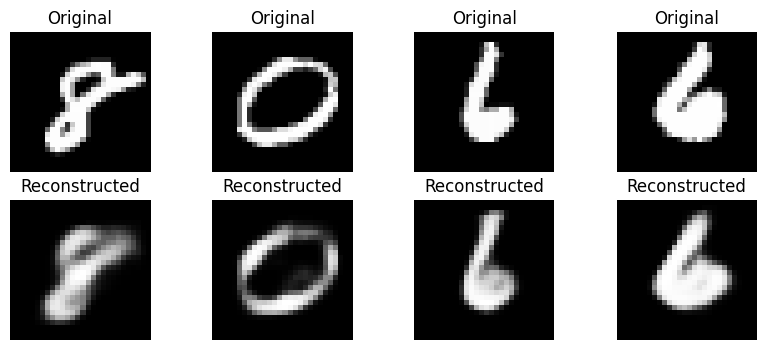

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 115.2160
Epoch 41: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 114.1433


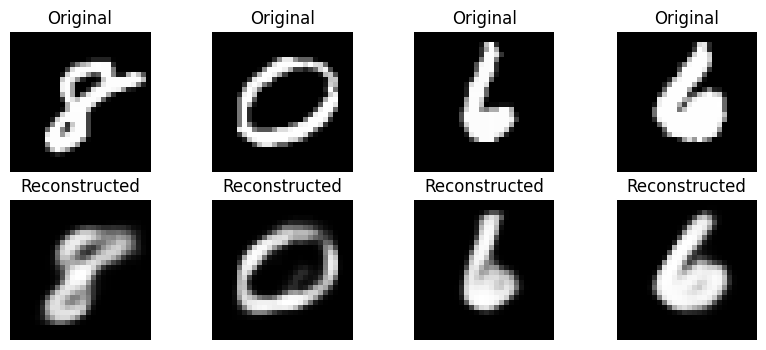

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 115.1474


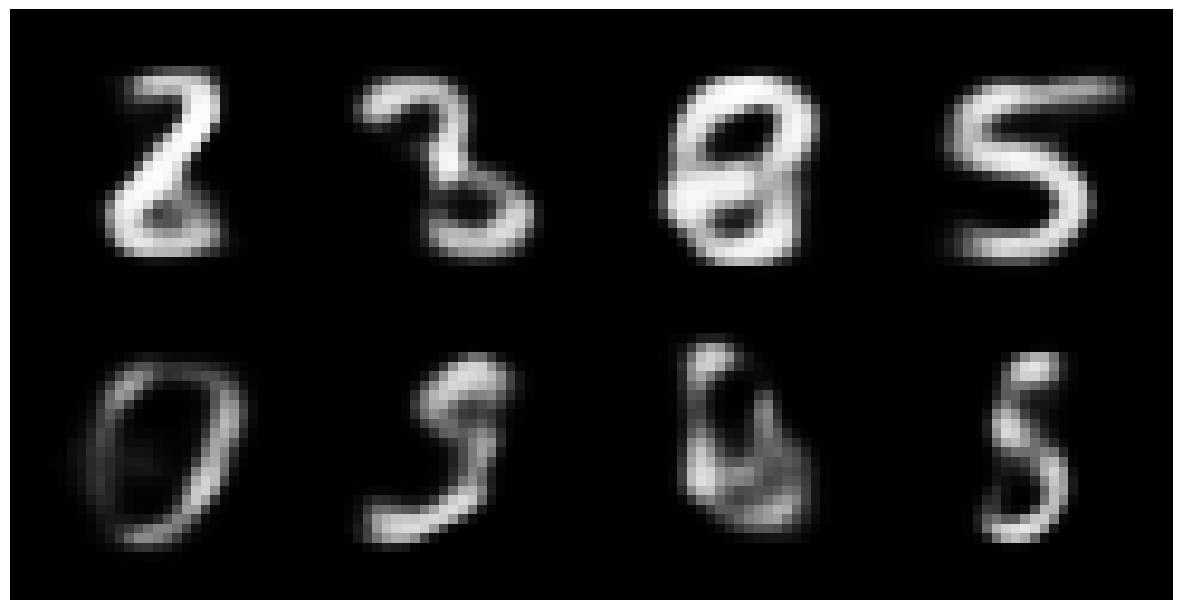

Epoch 42: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 114.0316


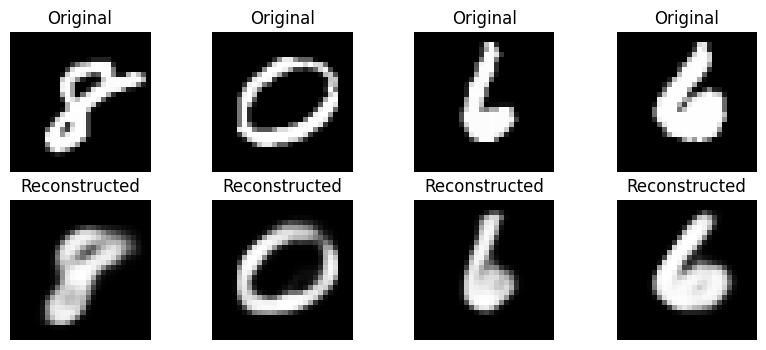

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 115.0188
Epoch 43: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 113.9149


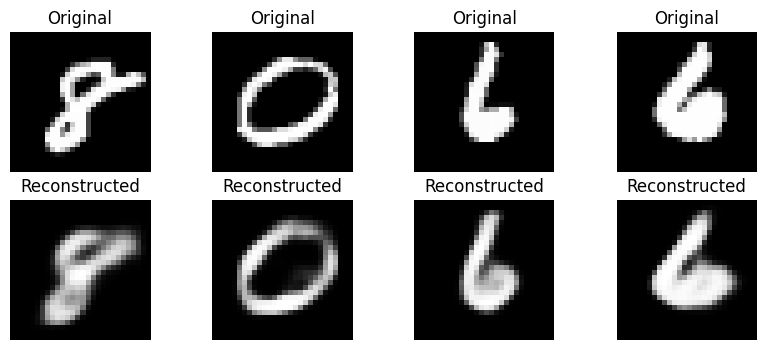

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 114.8469
Epoch 44: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 113.7993


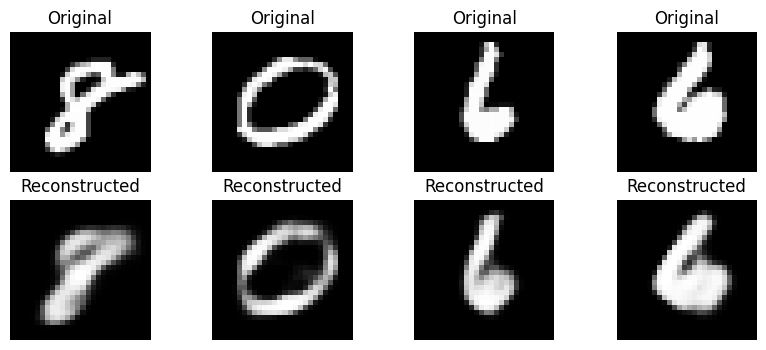

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 114.7404
Epoch 45: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 113.6809


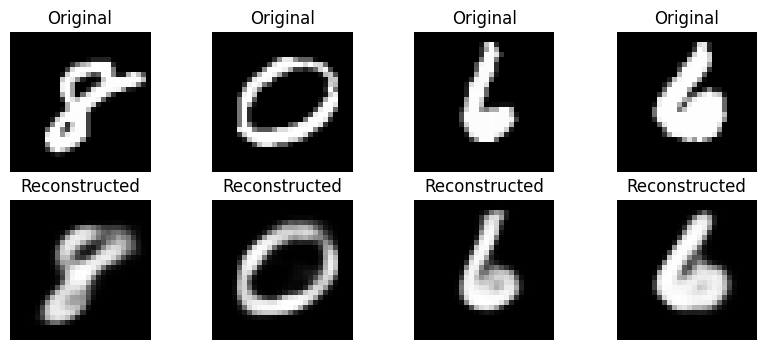

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 114.6530
Epoch 46: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 113.5390


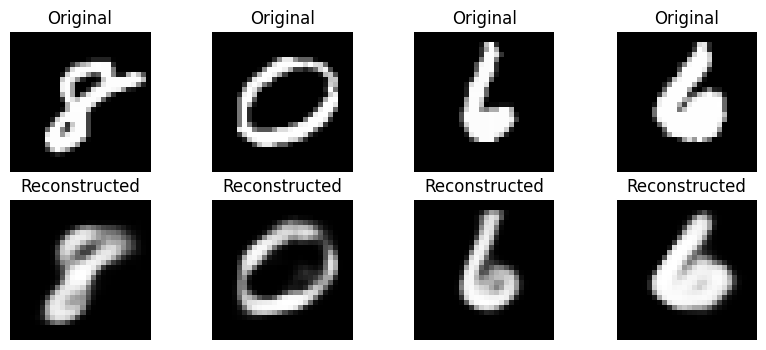

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 114.5807
Epoch 47: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 113.4459


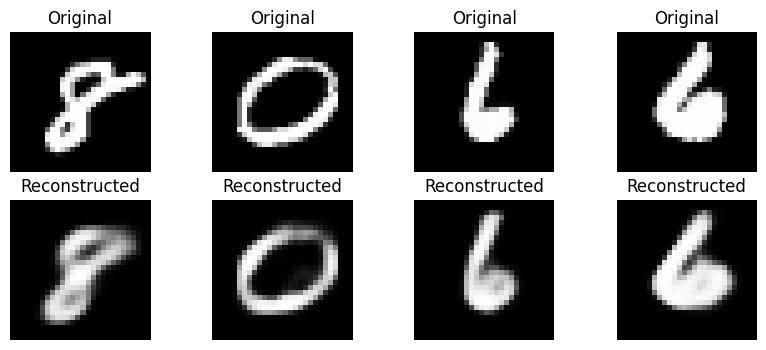

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 114.4489
Epoch 48: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 113.3131


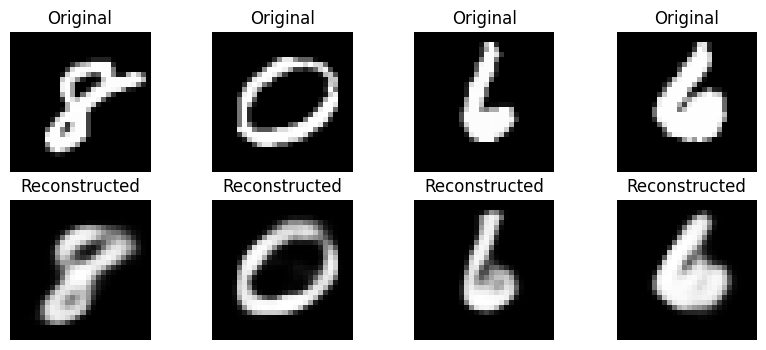

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 114.3118
Epoch 49: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 113.2349


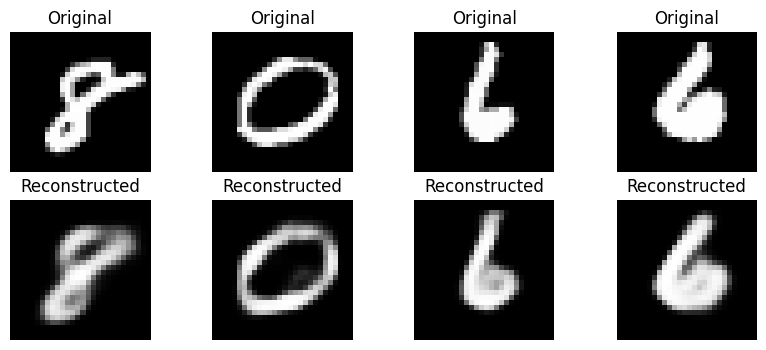

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 114.2115
Epoch 50: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 113.1177


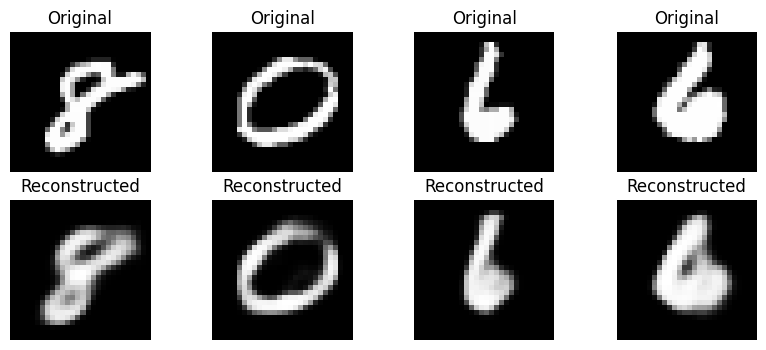

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 114.1991
Epoch 51: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 113.0222


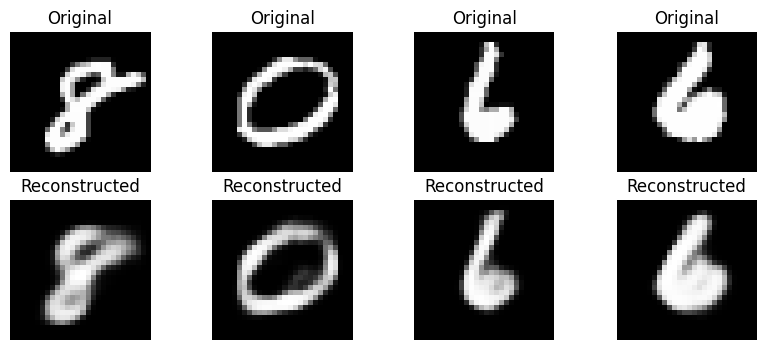

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 114.0864


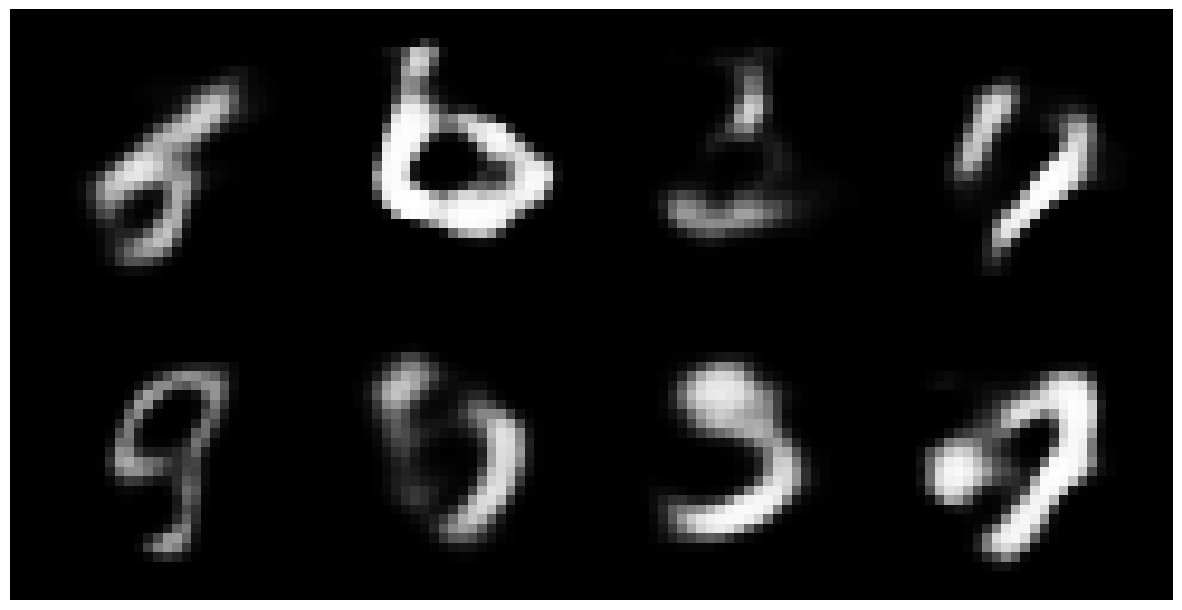

Epoch 52: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 112.9202


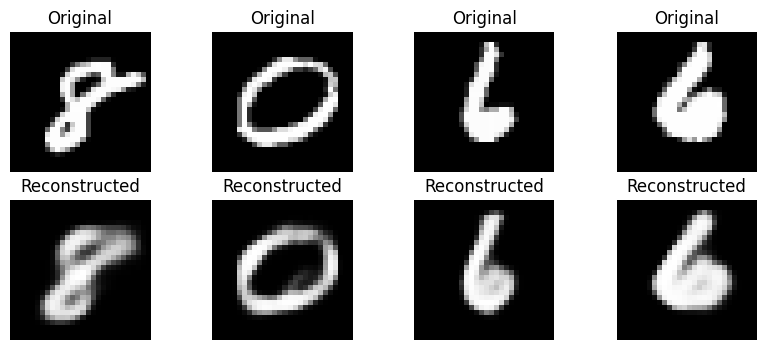

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 114.0067
Epoch 53: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 112.8621


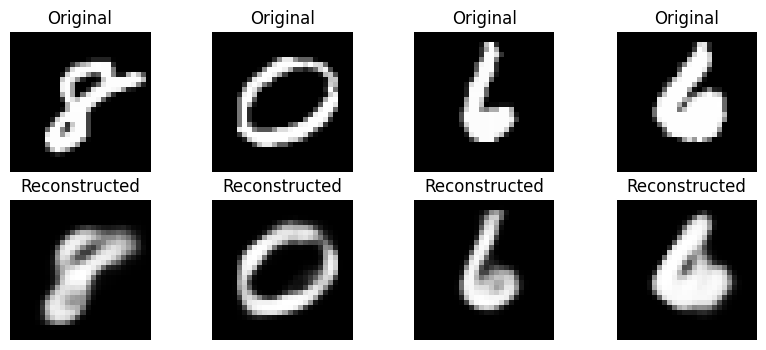

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 113.9424
Epoch 54: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 112.7637


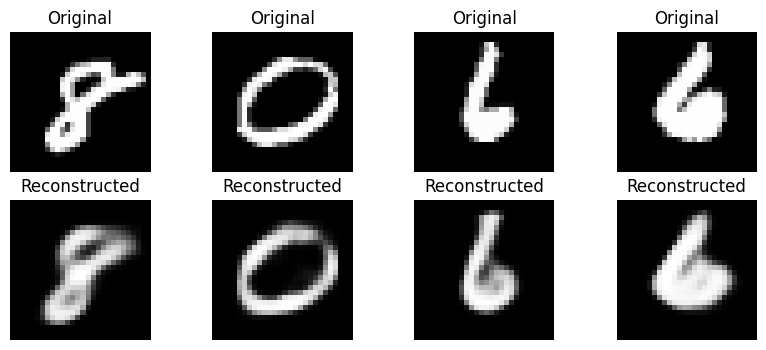

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 113.8569
Epoch 55: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 112.6636


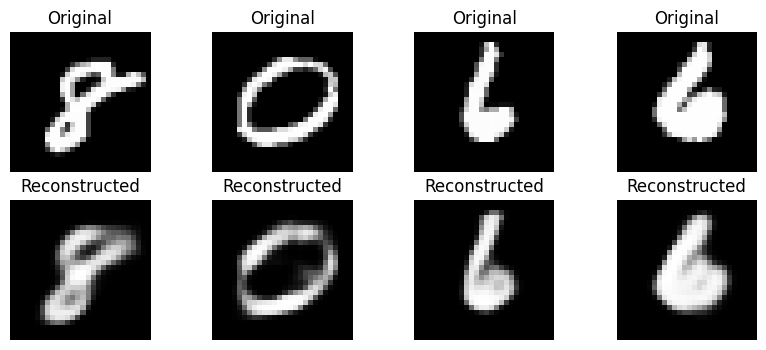

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 113.7995
Epoch 56: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 112.5680


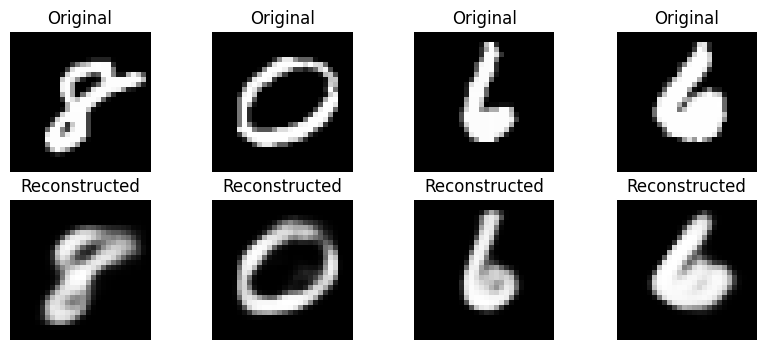

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 113.6218
Epoch 57: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 112.5181


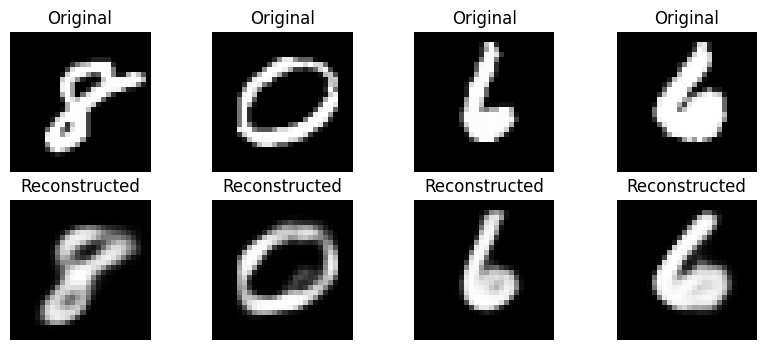

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 113.5060
Epoch 58: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 112.4199


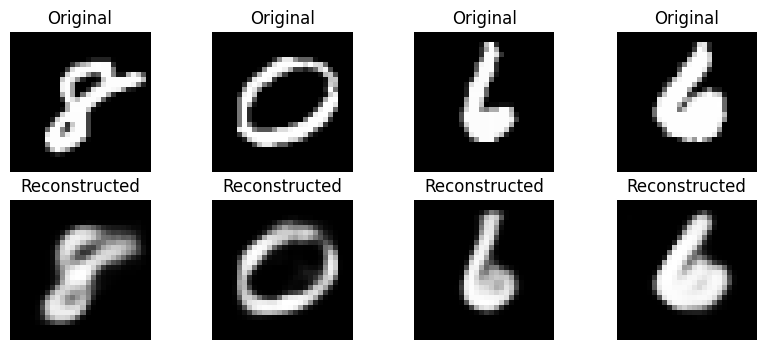

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 113.5116
Epoch 59: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 112.3372


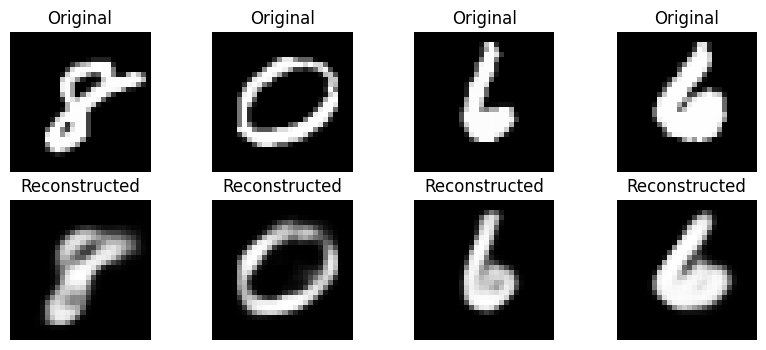

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 113.4186
Epoch 60: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 112.2272


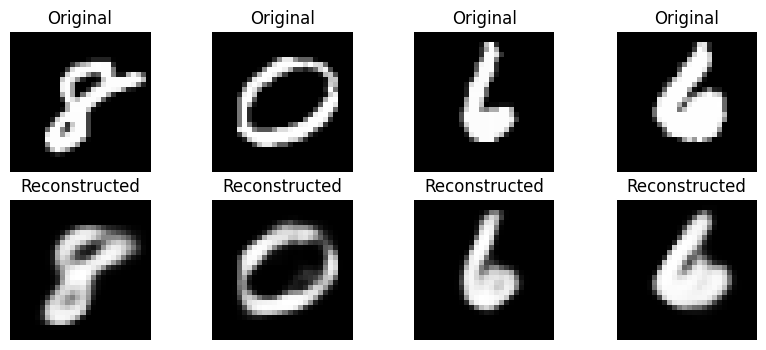

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 113.3754
Epoch 61: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 112.1745


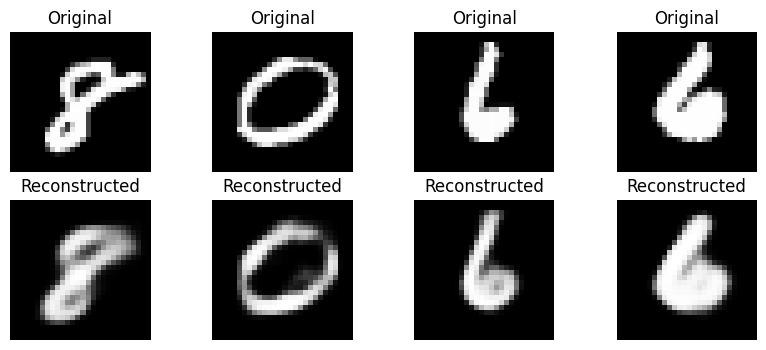

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 113.2738


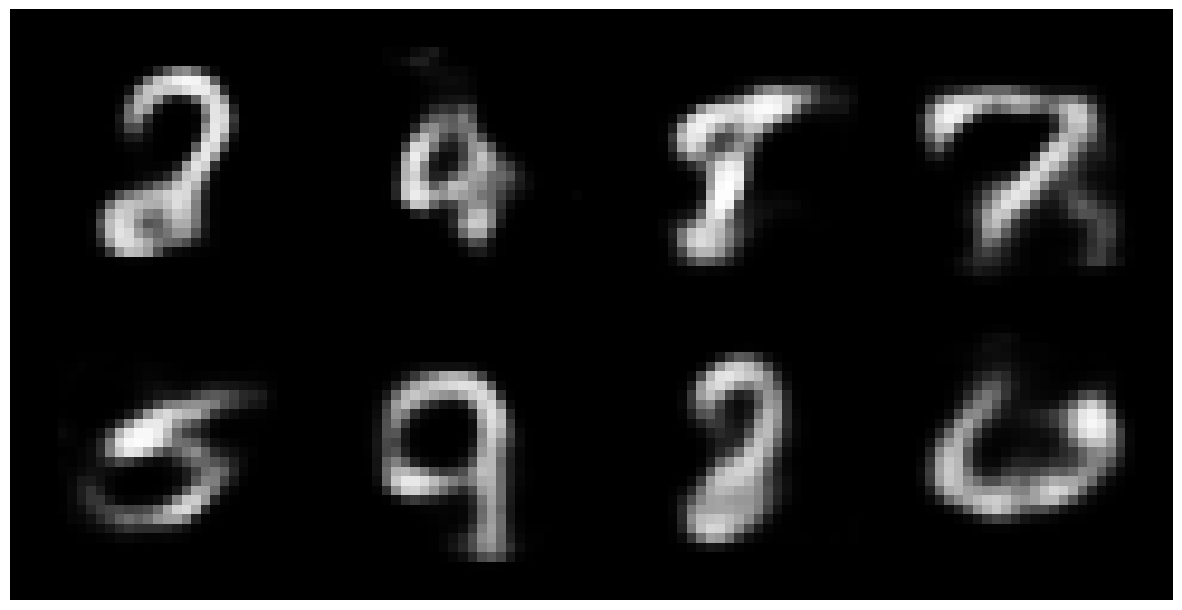

Epoch 62: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 112.0958


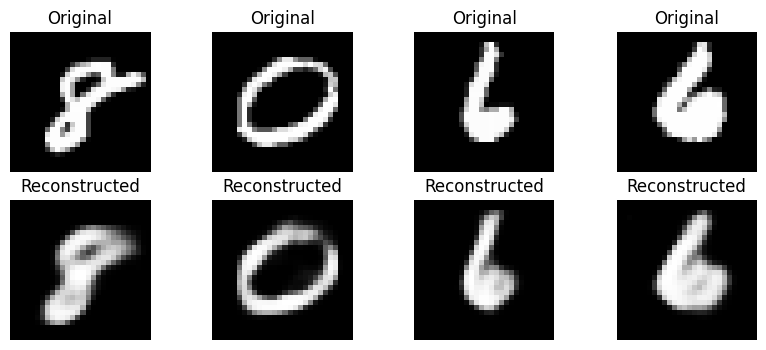

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 113.1960
Epoch 63: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 112.0178


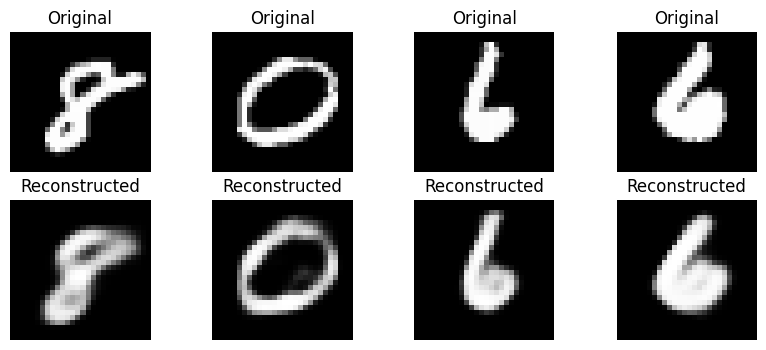

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 113.2329
Epoch 64: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 111.9614


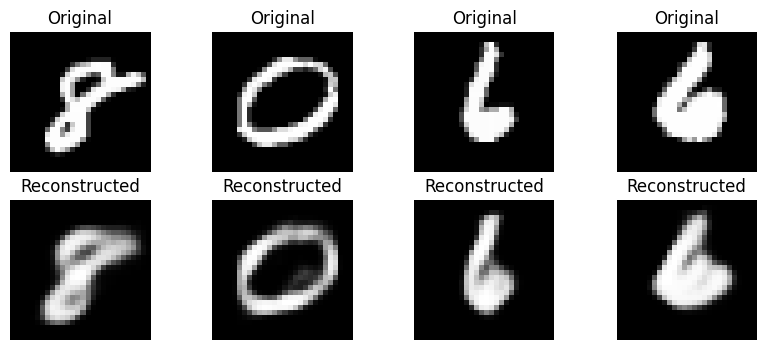

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 113.1292
Epoch 65: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 111.8695


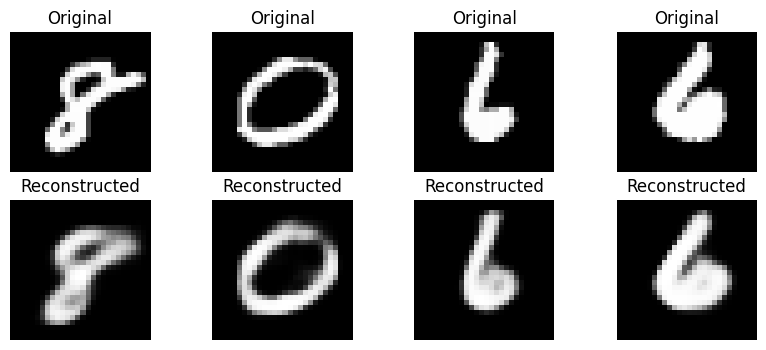

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.9558
Epoch 66: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 111.7764


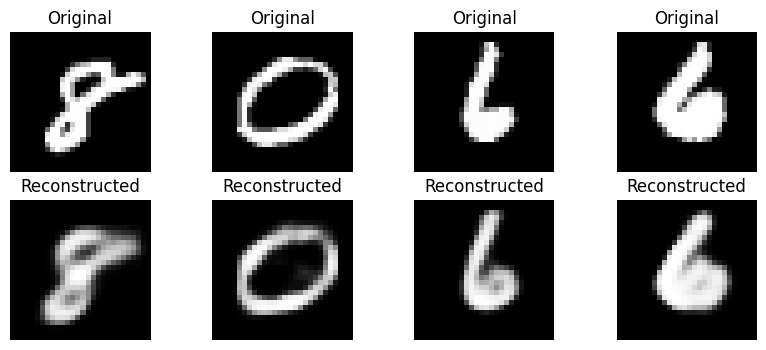

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.9731
Epoch 67: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 111.7473


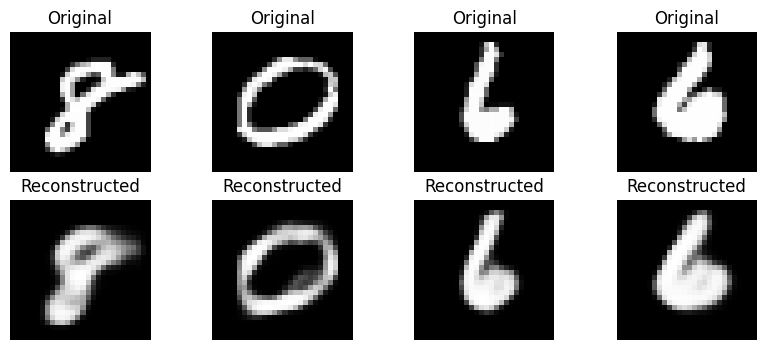

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.9209
Epoch 68: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 111.6774


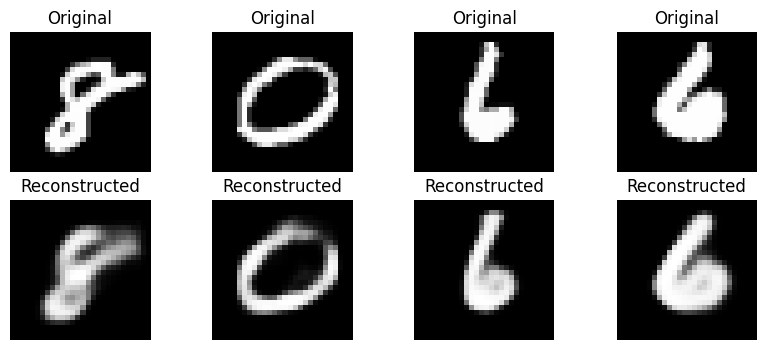

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.8636
Epoch 69: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 111.5740


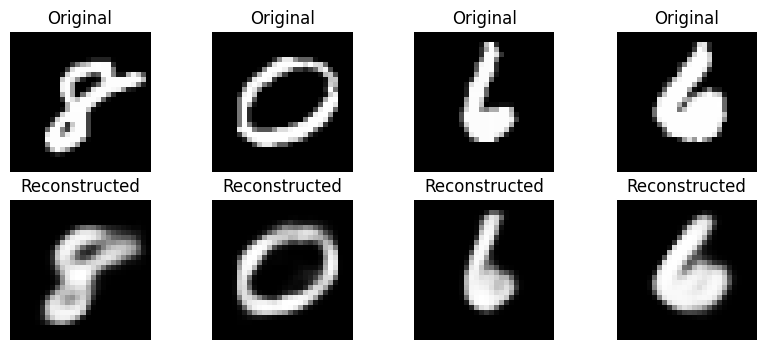

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.7568
Epoch 70: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 111.5225


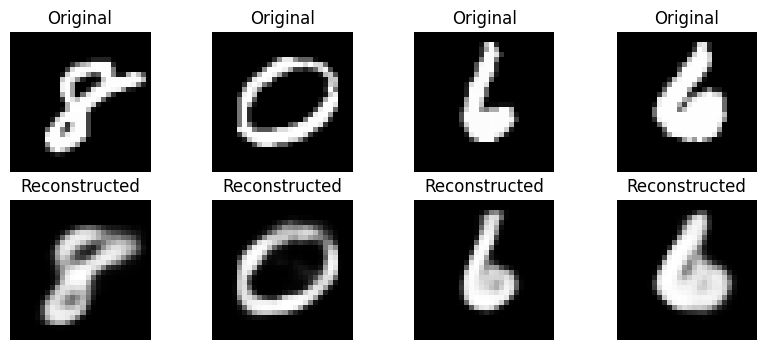

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.7033
Epoch 71: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 111.4673


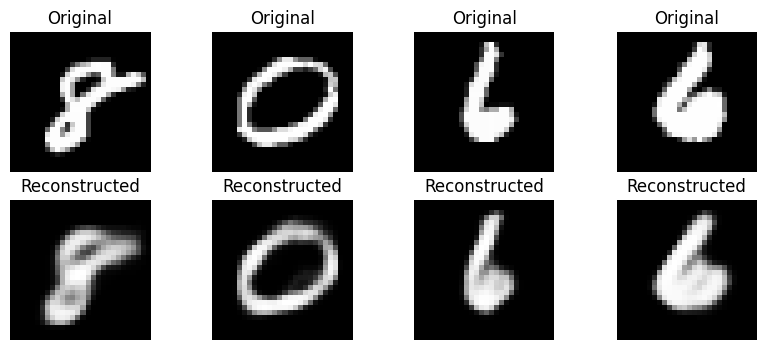

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.6764


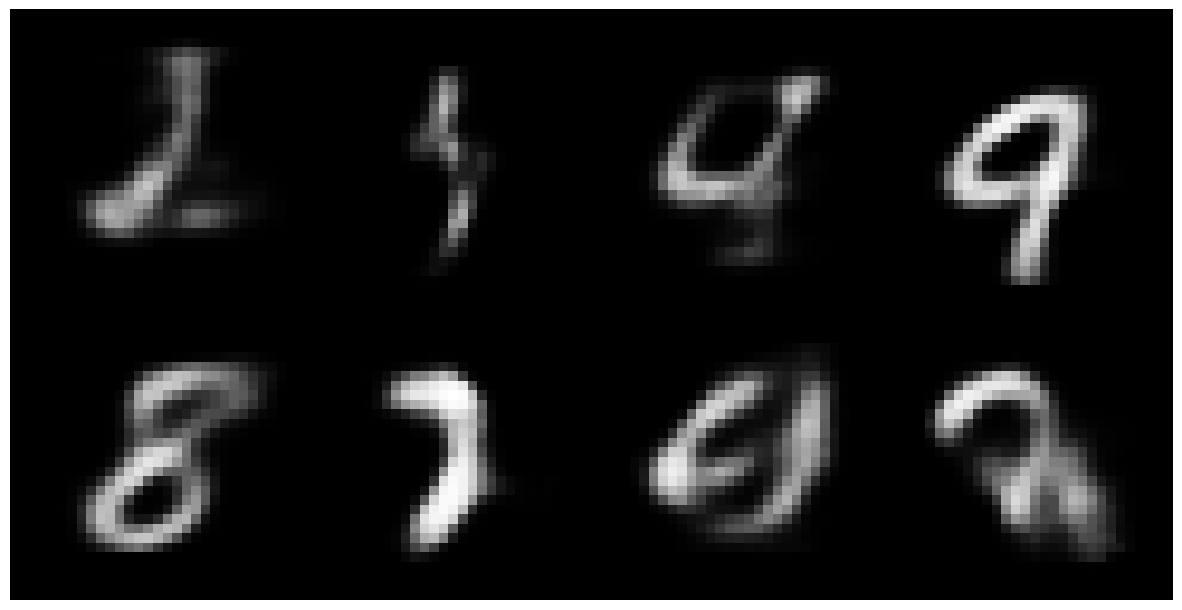

Epoch 72: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 111.4046


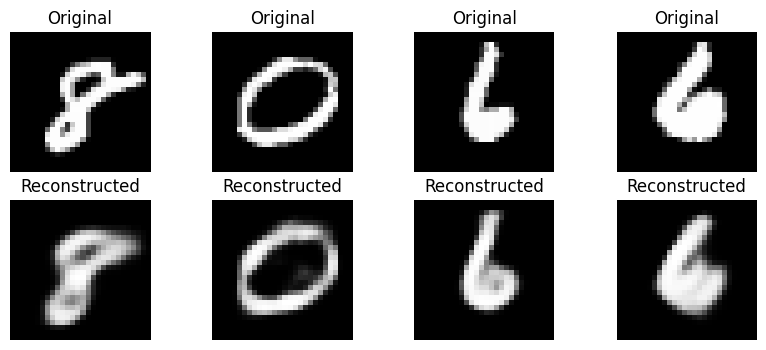

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.5749
Epoch 73: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 111.3295


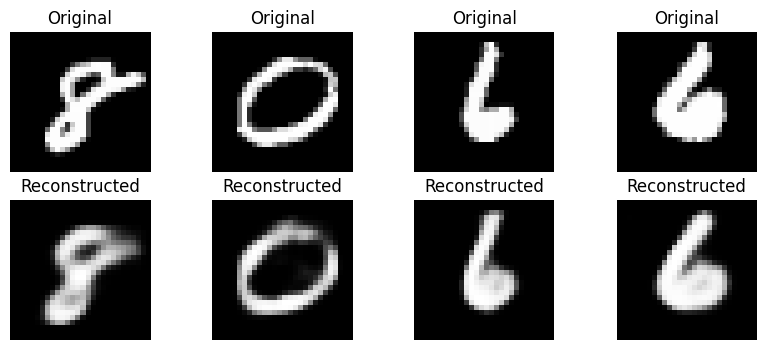

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.5372
Epoch 74: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 111.2713


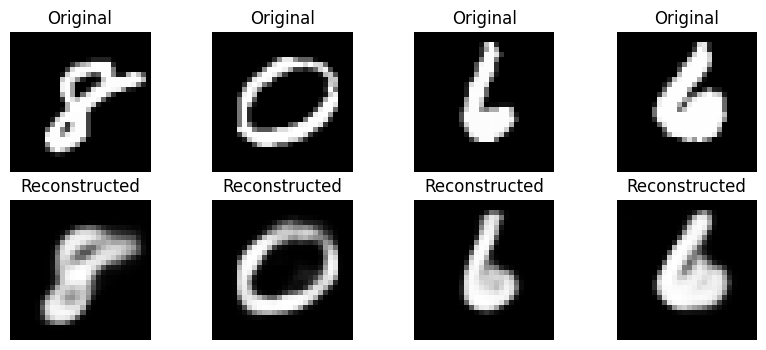

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.4758
Epoch 75: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 111.1909


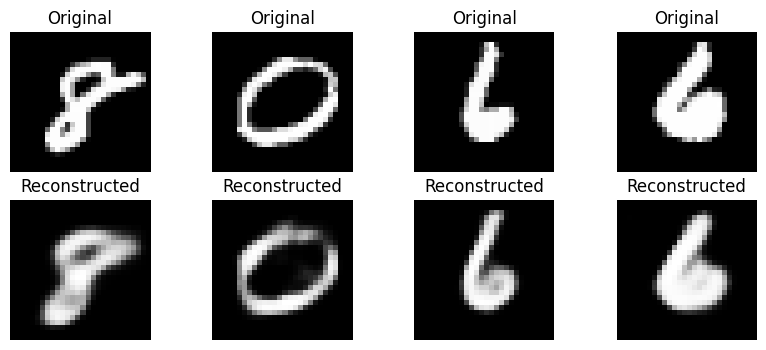

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.4752
Epoch 76: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 111.1407


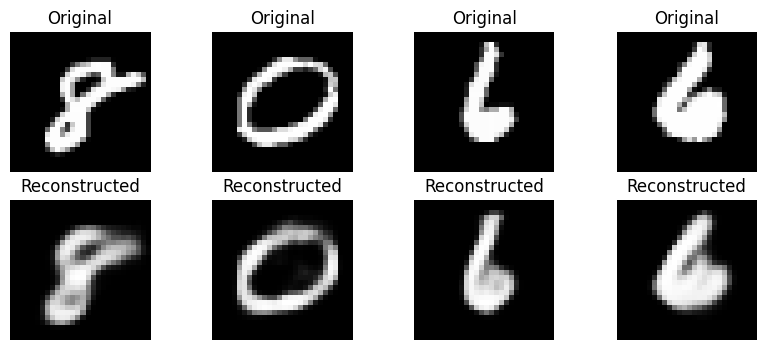

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.4033
Epoch 77: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 111.0847


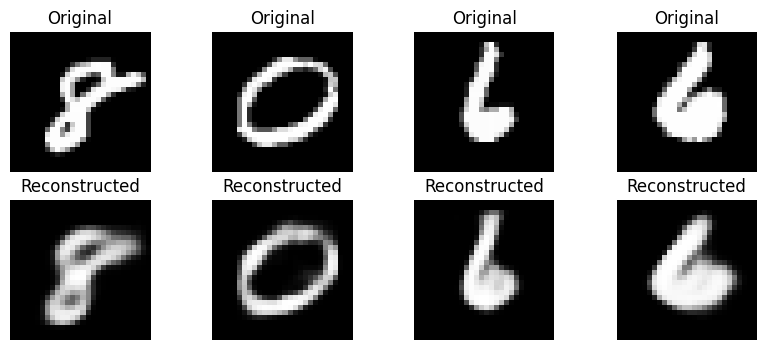

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.3701
Epoch 78: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 111.0399


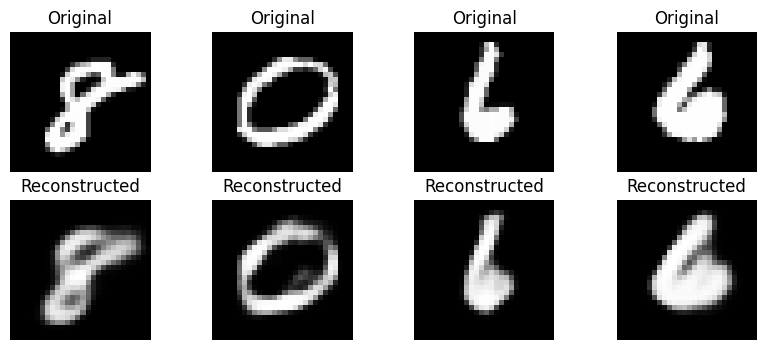

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.2705
Epoch 79: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 110.9880


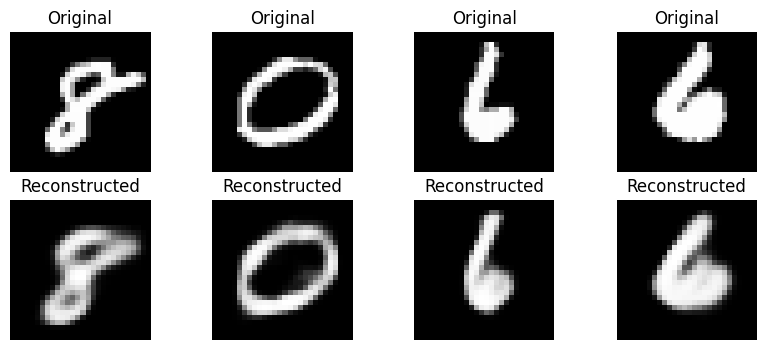

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.3311
Epoch 80: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 110.9203


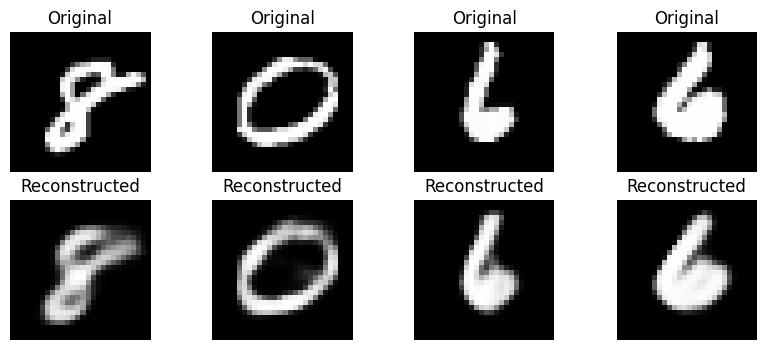

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.2091
Epoch 81: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 110.8724


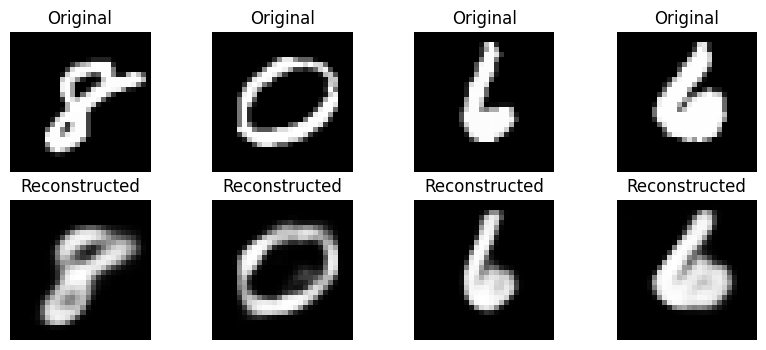

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.1379


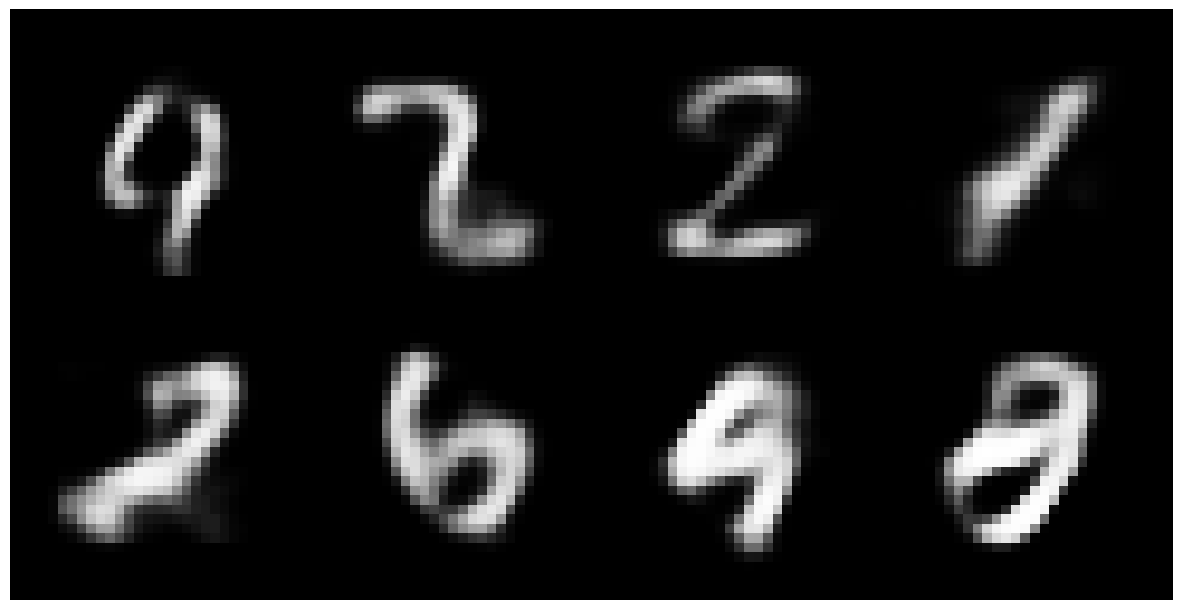

Epoch 82: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 110.8005


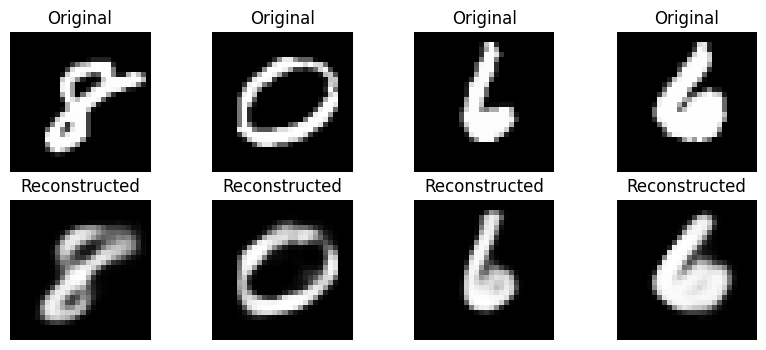

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.2675
Epoch 83: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 110.7613


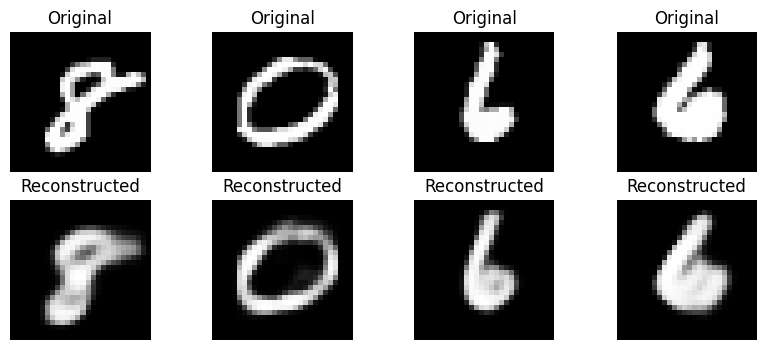

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.0216
Epoch 84: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 110.7130


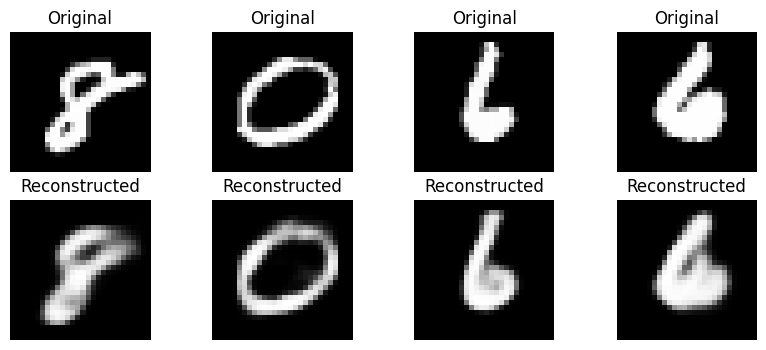

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.9786
Epoch 85: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 110.6445


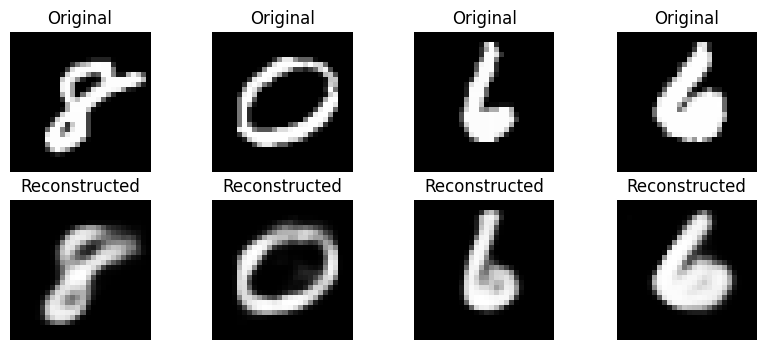

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.9219
Epoch 86: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 110.6121


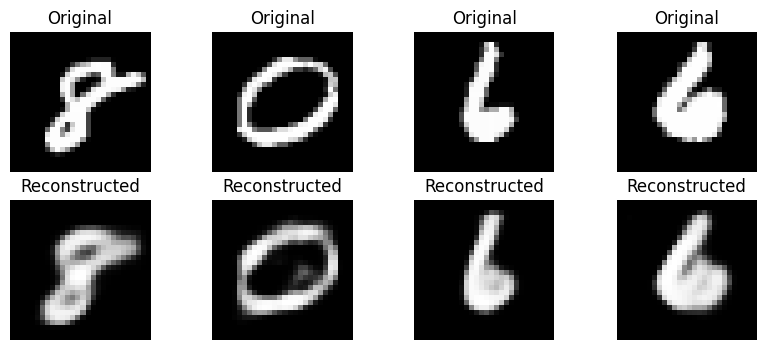

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.9693
Epoch 87: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 110.5816


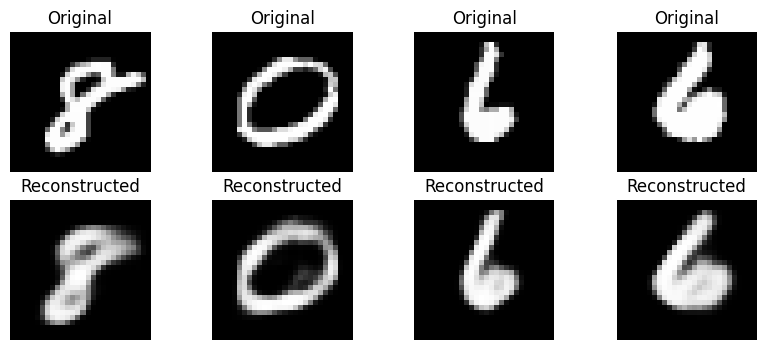

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.8314
Epoch 88: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 110.4689


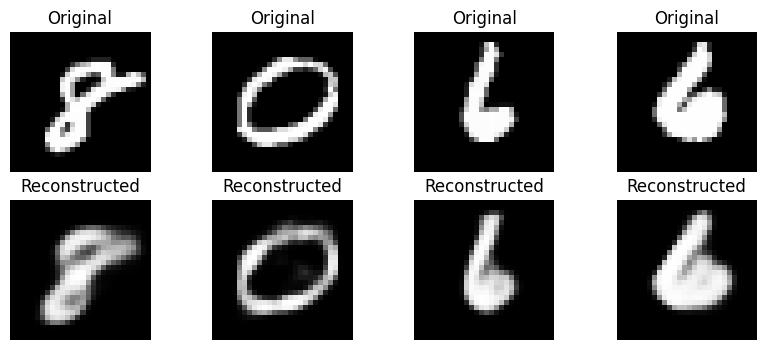

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.7789
Epoch 89: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 110.4896


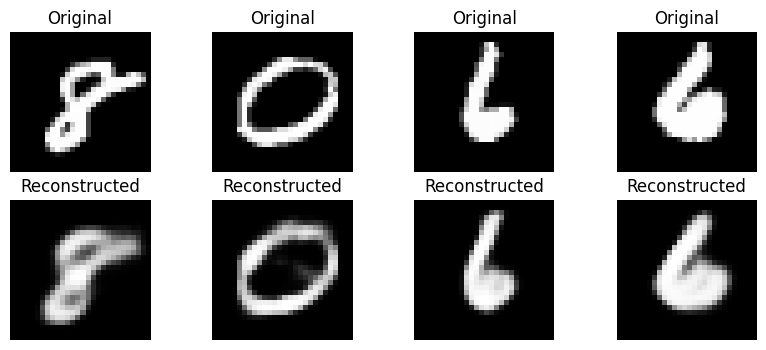

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.8055
Epoch 90: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 110.4123


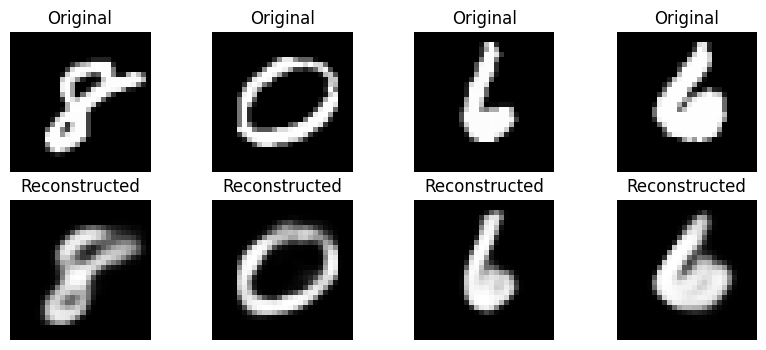

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.7845
Epoch 91: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 110.3444


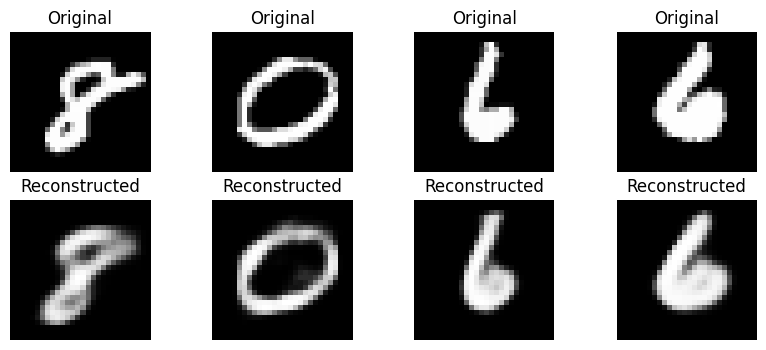

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.7287


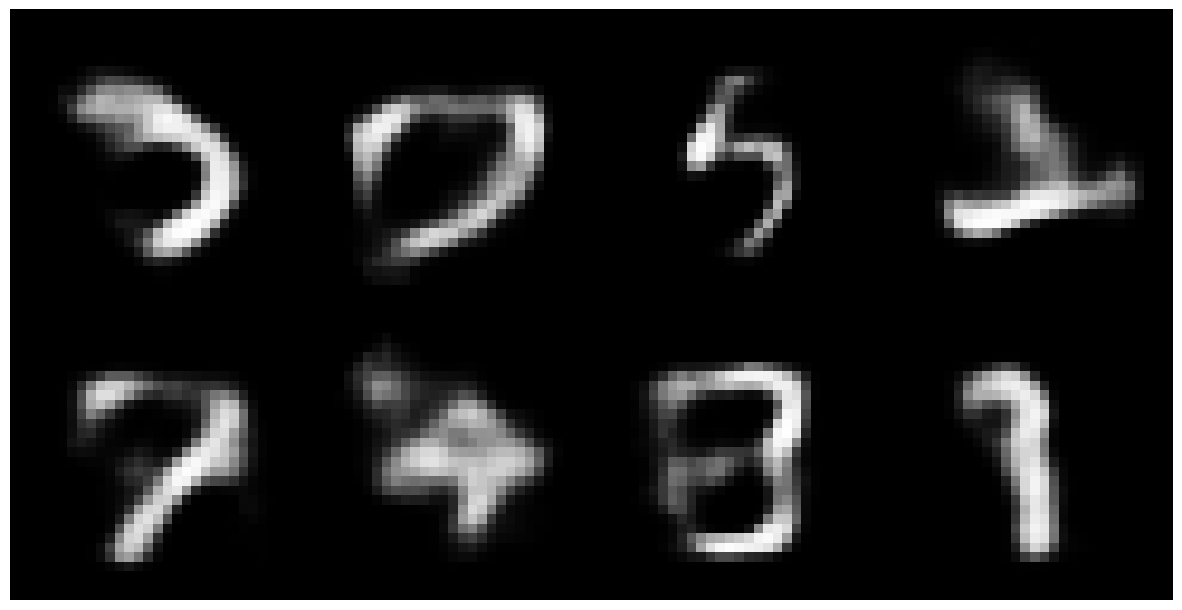

Epoch 92: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 110.3120


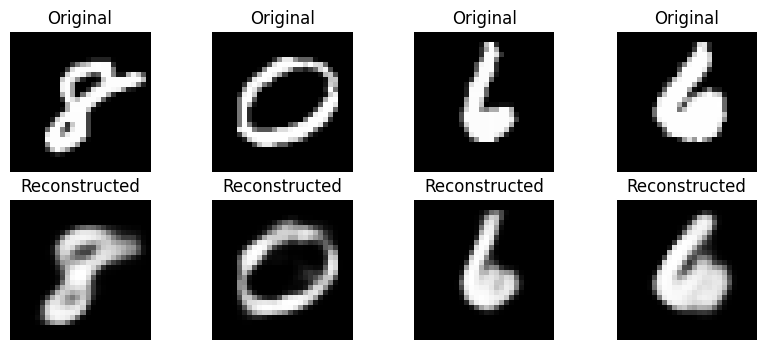

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.6756
Epoch 93: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 110.2489


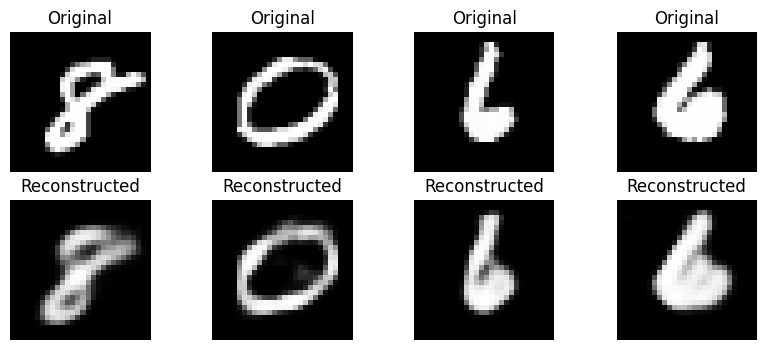

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.6328
Epoch 94: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 110.2192


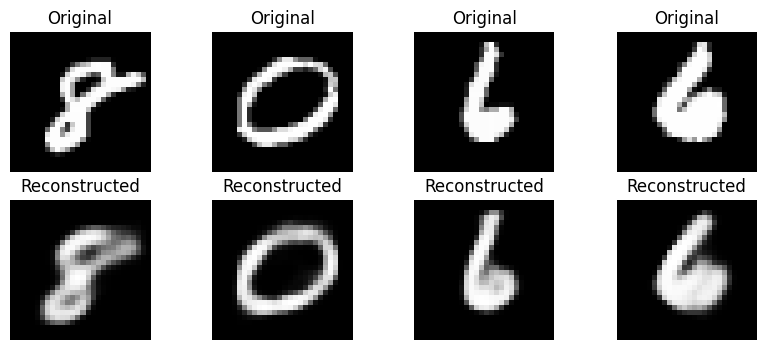

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.5871
Epoch 95: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 110.1661


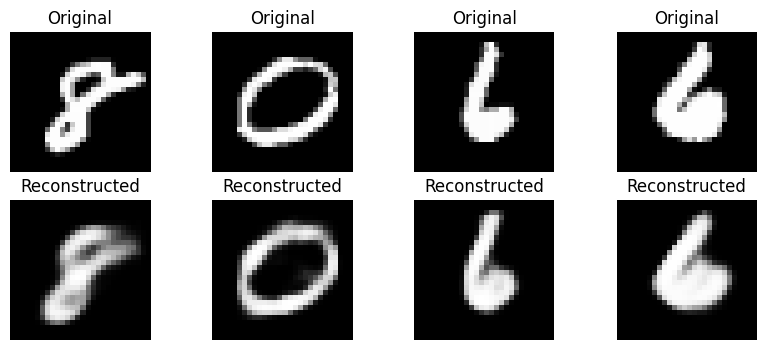

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.5069
Epoch 96: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 110.1099


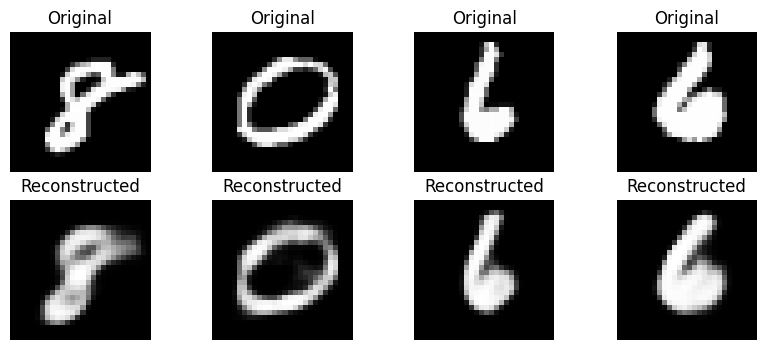

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.5363
Epoch 97: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 110.1017


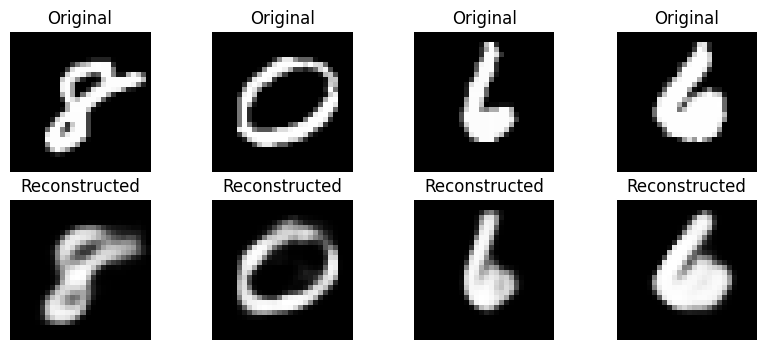

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.4949
Epoch 98: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 110.0289


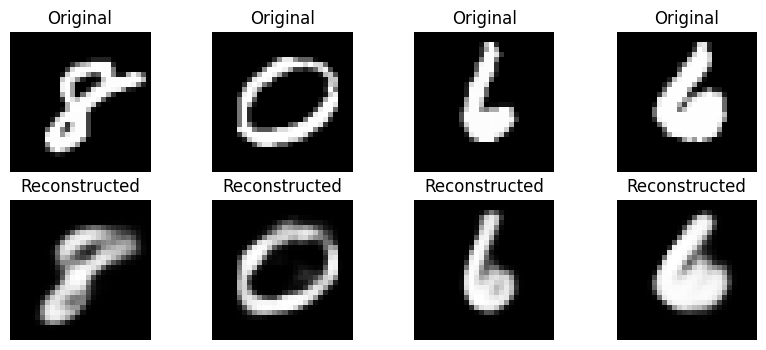

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.3999
Epoch 99: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 109.9746


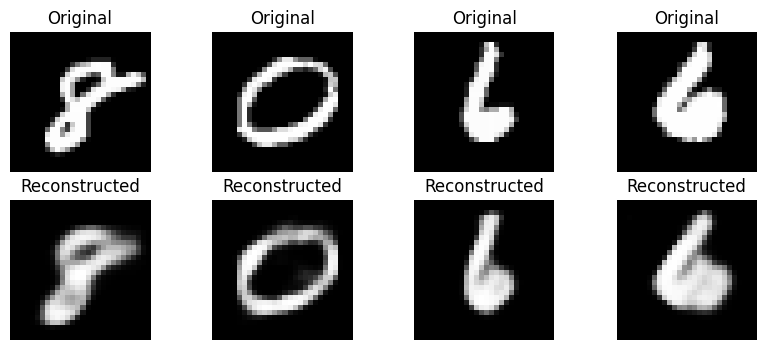

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.4291
Epoch 100: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 109.9542


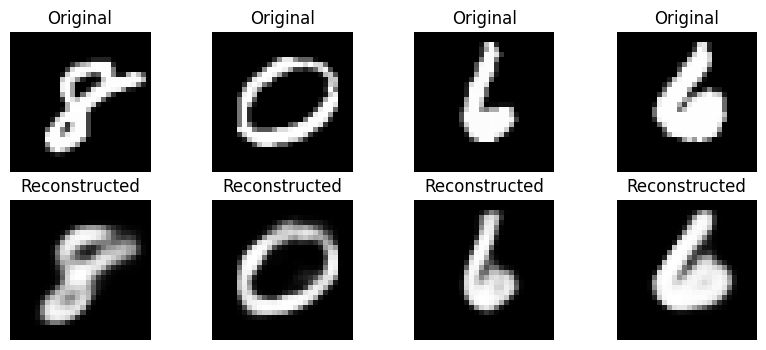

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.2676


In [16]:
input_dim = 784
hidden_dim = 256
latent_dim = 10
model, vae_val_loss = train_vae(train_loader, val_loader, latent_dim, hidden_dim, input_dim, num_epochs=100)

In [17]:
torch.save(model.state_dict(), data_path+'vae_model.pth')

# GAN

GANs consist of two models: a generator and a discriminator. The generator creates new data points, and the discriminator evaluates them, trying to distinguish between real and generated (fake) data points. The training process involves updating the generator to produce more realistic data, as judged by the discriminator, and simultaneously updating the discriminator to get better at distinguishing real from fake. This adversarial process leads to improvements in both models, with the generator producing highly realistic data points as a result.

In [11]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()

        #######################
        # TODO
        # Define your generator
        #######################
        self.img_shape = img_shape

        self.model = nn.Sequential(
            # TODO
            # Project and reshape
            nn.Linear(latent_dim, 128 * 7 * 7),
            nn.ReLU(True),
            nn.Unflatten(1, (128, 7, 7)),

            # Upsample to 14x14
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # Upsample to 28x28
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Sigmoid() # Use Sigmoid to output pixel values in [0, 1]
        )

    def forward(self, z):
        ##############################################
        # TODO
        # generate an image using `z` vector, sampled
        # from a prior distribution.
        # Reshape the result to the shape of original images
        ##############################################
        img = self.model(z)
        # The view is handled implicitly by the model layers, but this is good for ensuring shape
        img = img.view(img.size(0), *self.img_shape)
        return img

class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super(Discriminator, self).__init__()

        ###########################
        # TODO
        # Define your discriminator
        ###########################
        self.model = nn.Sequential(
            # TODO
            # Input: 1 x 28 x 28
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # State: 64 x 14 x 14
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # State: 128 x 7 x 7
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        ##############################################
        # TODO
        # Predict whether each image in `img` is real or fake.
        ##############################################
        validity = self.model(img)
        return validity

In [12]:
def train_gan(dataloader, val_loader, latent_dim, img_shape=(1, 28, 28), learning_rate=3e-4, num_epochs=100):
    ###############################################
    # TODO
    # Define the loss fc, optimizers, generator and discriminator.
    ###############################################
    generator = Generator(latent_dim, img_shape).to(DEVICE)
    discriminator = Discriminator(img_shape).to(DEVICE)
    adversarial_loss = nn.BCELoss().to(DEVICE)
    optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

    val_gen_losses, val_dis_losses = [], []
    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, (imgs, _) in pbar:

                ##########################################################
                # TODO
                # Calculate the loss for the Generator and the Discriminator.
                ##########################################################

                # Move data to the configured device
                real_imgs = imgs.to(DEVICE)

                # Adversarial ground truths
                valid = torch.ones(imgs.size(0), 1, device=DEVICE)
                fake = torch.zeros(imgs.size(0), 1, device=DEVICE)

                # -----------------
                #  Train Generator
                # -----------------
                optimizer_G.zero_grad()

                # Sample noise as generator input
                z = torch.randn(imgs.size(0), latent_dim, device=DEVICE)

                # Generate a batch of images
                gen_imgs = generator(z)

                # Loss measures generator's ability to fool the discriminator
                g_loss = adversarial_loss(discriminator(gen_imgs), valid)

                g_loss.backward()
                optimizer_G.step()

                # ---------------------
                #  Train Discriminator
                # ---------------------
                optimizer_D.zero_grad()

                # Measure discriminator's ability to classify real images
                real_loss = adversarial_loss(discriminator(real_imgs), valid)

                # Measure discriminator's ability to classify fake images
                fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)

                d_loss = (real_loss + fake_loss) / 2

                d_loss.backward()
                optimizer_D.step()

                # TODO
                # Calculate and fill discriminator and generator losses
                pbar.set_description("[epoch: {}/{}] [D loss: {:.4f}] [G loss: {:.4f}]".format(epoch+1, num_epochs, d_loss.item(), g_loss.item()))

        # TODO
        # Plot generated images after each epoch
        generator.eval()
        discriminator.eval()
        val_loss = [0., 0.]
        with torch.no_grad():
          with tqdm(enumerate(val_loader), total=len(val_loader)) as vbar:
              for i, (imgs, _) in vbar:

                  ##########################################################
                  # TODO
                  # Calculate the loss for the Generator and the Discriminator.
                  ##########################################################
                  real_imgs = imgs.to(DEVICE)

                  # Adversarial ground truths
                  valid = torch.ones(imgs.size(0), 1, device=DEVICE)
                  fake = torch.zeros(imgs.size(0), 1, device=DEVICE)

                  # Sample noise
                  z = torch.randn(imgs.size(0), latent_dim, device=DEVICE)
                  gen_imgs = generator(z)

                  # Calculate losses
                  g_loss = adversarial_loss(discriminator(gen_imgs), valid)
                  real_loss_val = adversarial_loss(discriminator(real_imgs), valid)
                  fake_loss_val = adversarial_loss(discriminator(gen_imgs.detach()), fake)
                  d_loss = (real_loss_val + fake_loss_val) / 2

                  # TODO
                  # Calculate and fill discriminator and generator losses
                  vbar.set_description("[Validation] [D loss: {:.4f}] [G loss: {:.4f}]".format(d_loss.item(), g_loss.item()))
                  val_loss[0] = val_loss[0] + g_loss.item()
                  val_loss[1] = val_loss[1] + d_loss.item()

              val_gen_losses.append(val_loss[0] / len(val_loader))
              val_dis_losses.append(val_loss[1] / len(val_loader))
              print("[Validation avg loss] ----- [D loss: {:.4f}] [G loss: {:.4f}]".format(val_dis_losses[-1], val_gen_losses[-1]))

        z = torch.randn(8, latent_dim).type_as(imgs).to(DEVICE)
        generated_imgs = generator(z)
        grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=True)
        plt.figure(figsize=(10, 10))
        plt.imshow(grid.cpu().permute(1, 2, 0))
        plt.show()

    return generator, discriminator, val_gen_losses, val_dis_losses

In [13]:
latent_dim = 100

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.3334] [G loss: 1.7101]


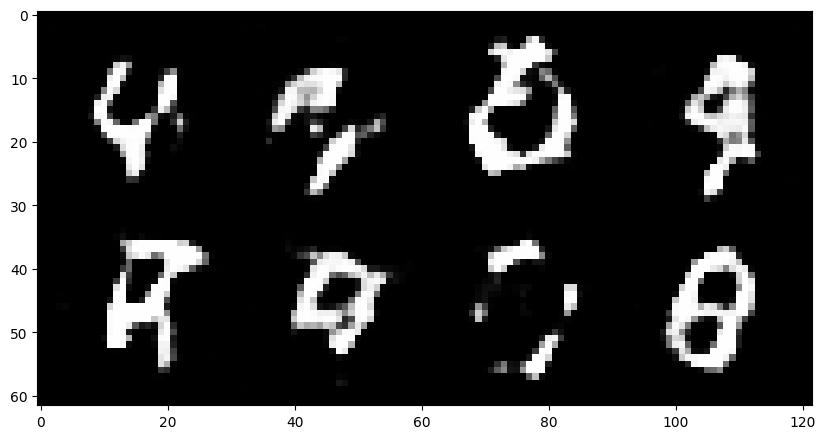

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.4156] [G loss: 2.2809]


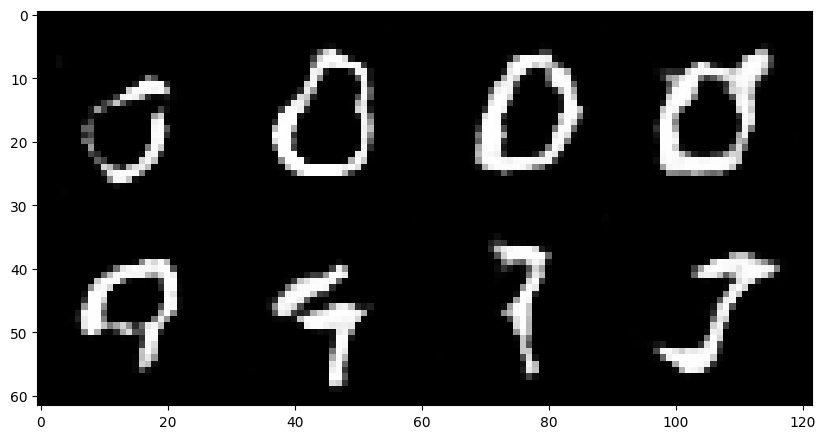

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.4634] [G loss: 2.0017]


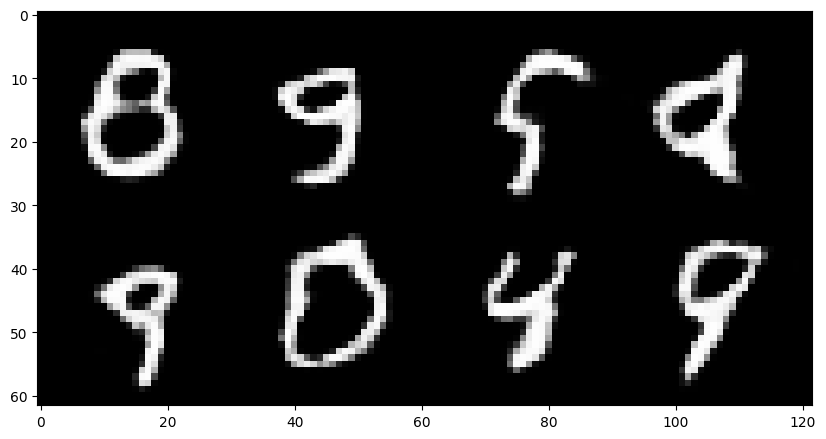

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.4136] [G loss: 2.2846]


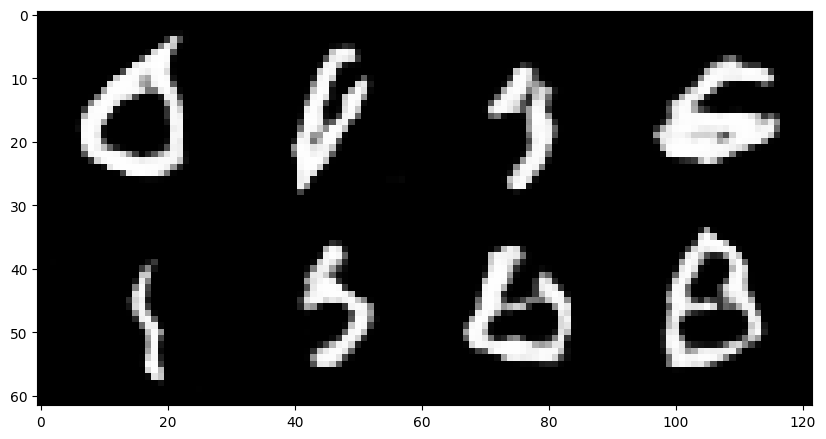

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 1.5799] [G loss: 5.9072]


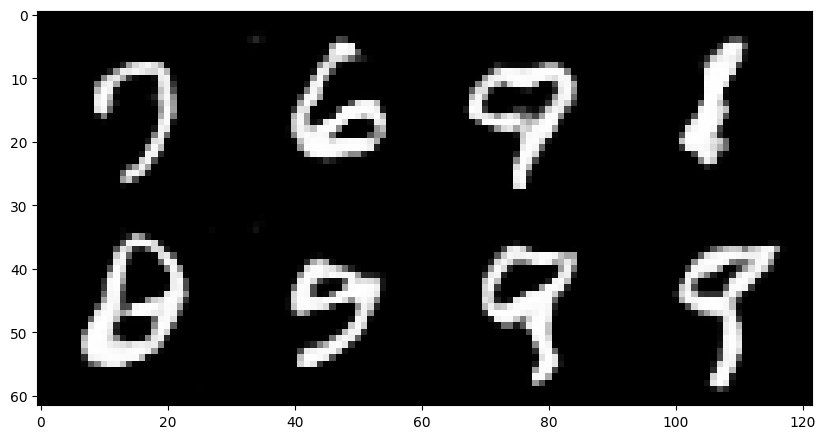

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 1.2890] [G loss: 5.1042]


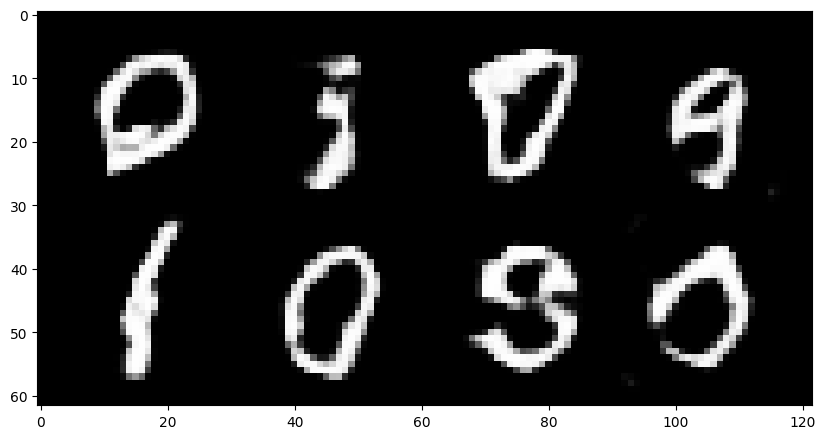

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 1.1011] [G loss: 4.7504]


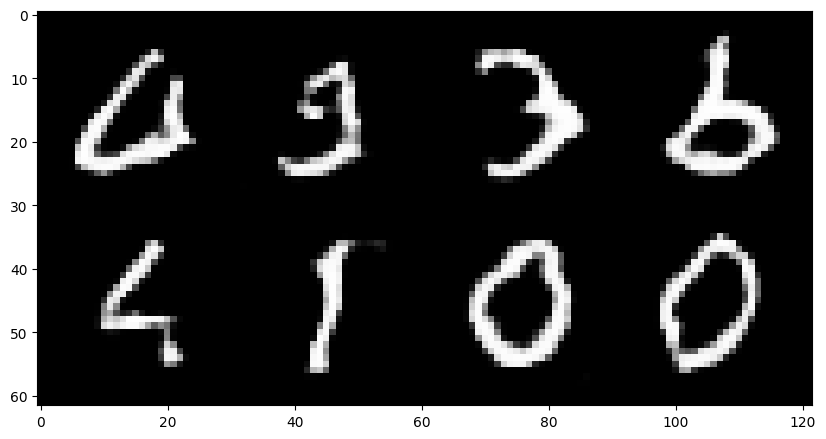

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.3947] [G loss: 2.5834]


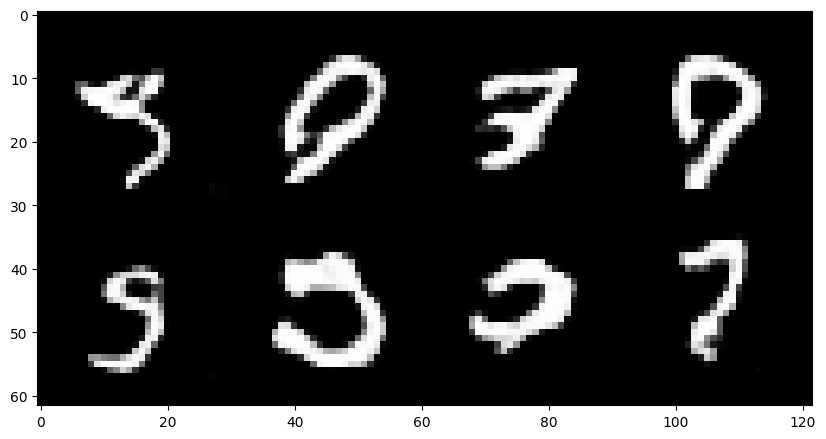

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.3754] [G loss: 2.0469]


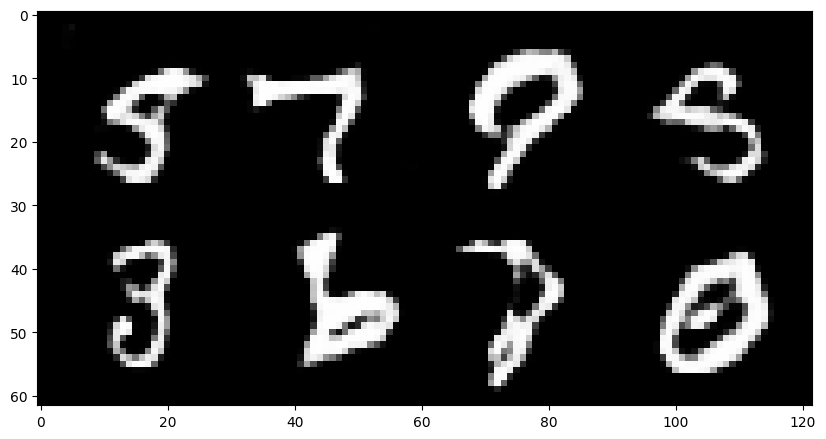

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.3824] [G loss: 1.6418]


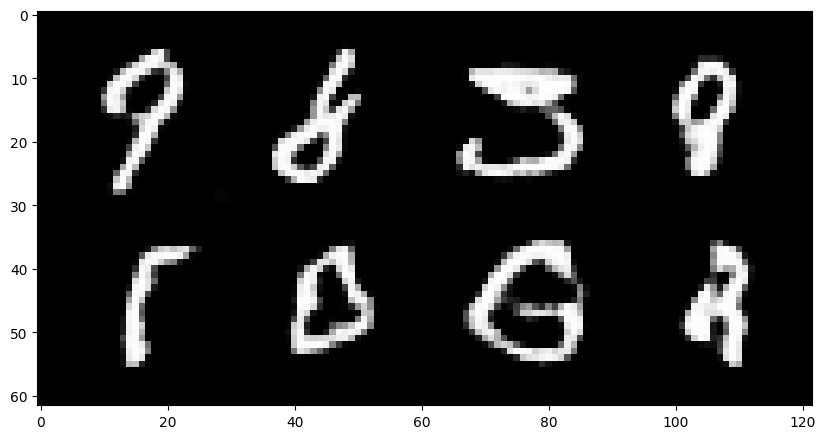

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.3709] [G loss: 2.1764]


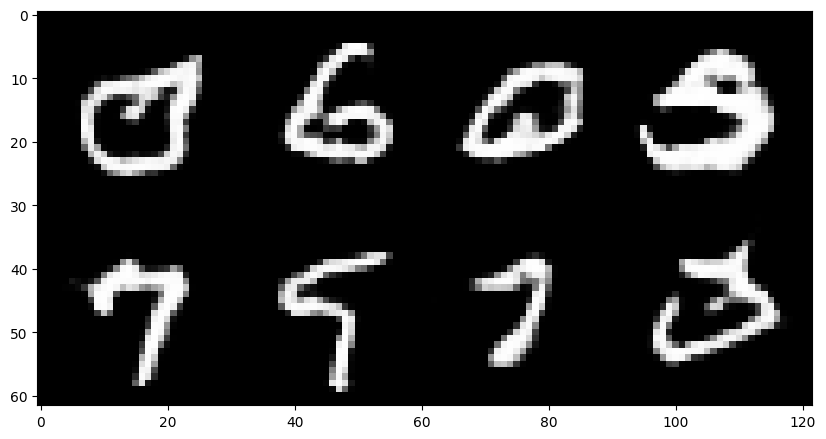

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 1.1152] [G loss: 0.4133]


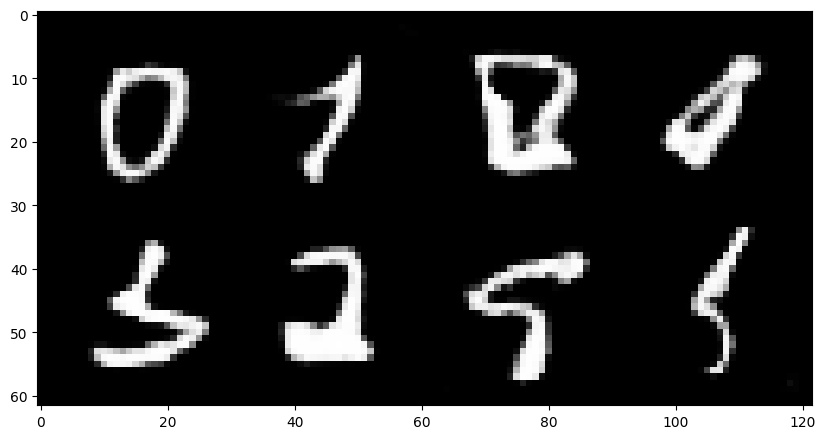

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.3588] [G loss: 2.0171]


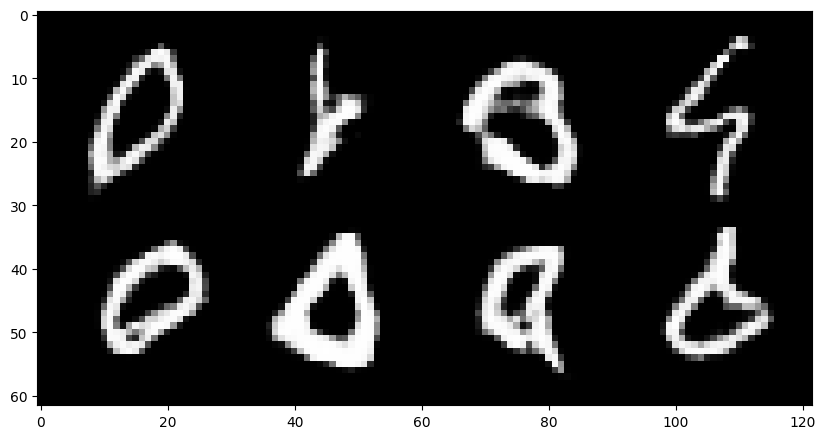

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.4450] [G loss: 1.1632]


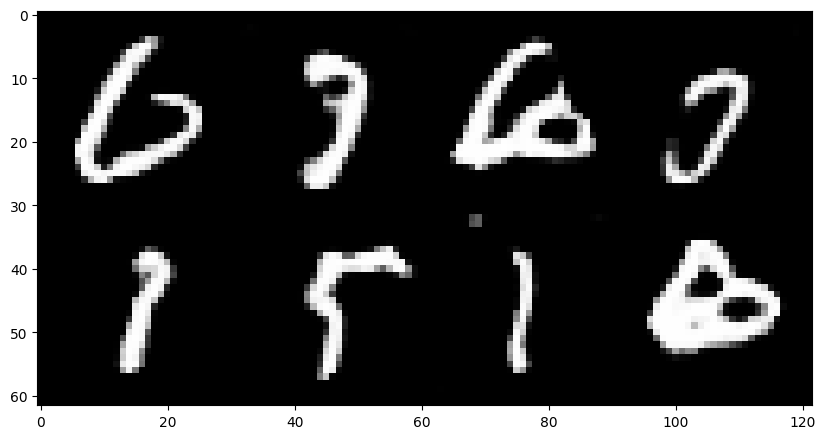

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.4364] [G loss: 1.4167]


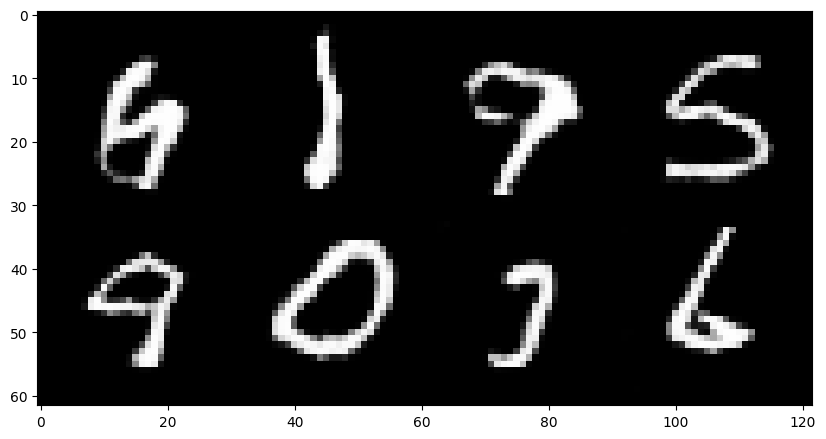

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.4737] [G loss: 2.7162]


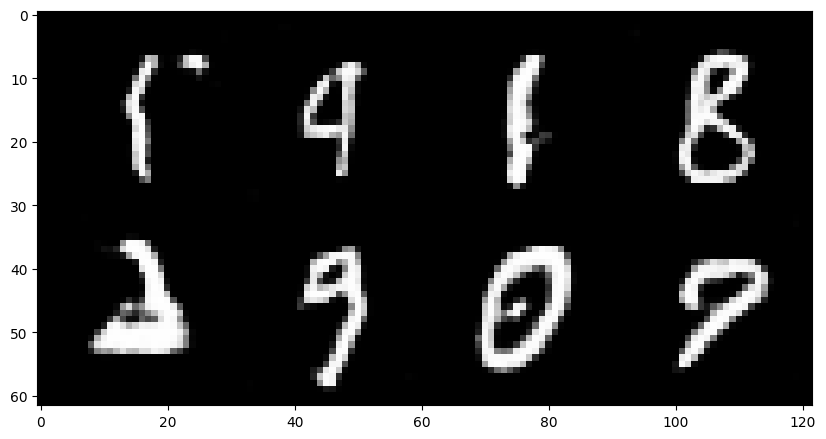

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.5487] [G loss: 3.3687]


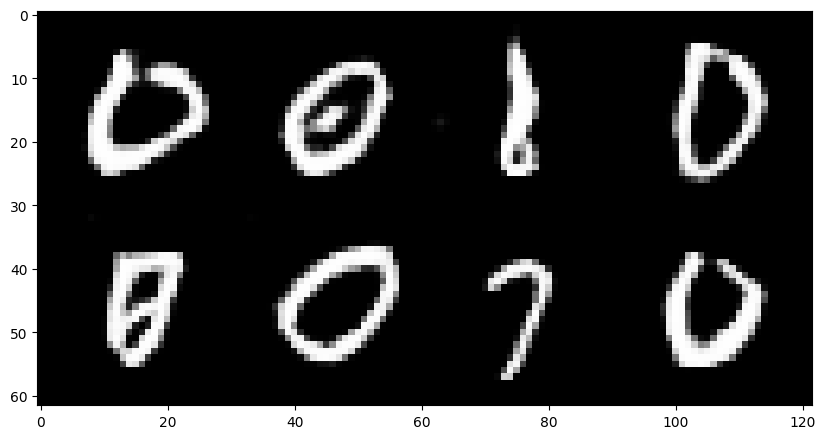

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.7647] [G loss: 0.6570]


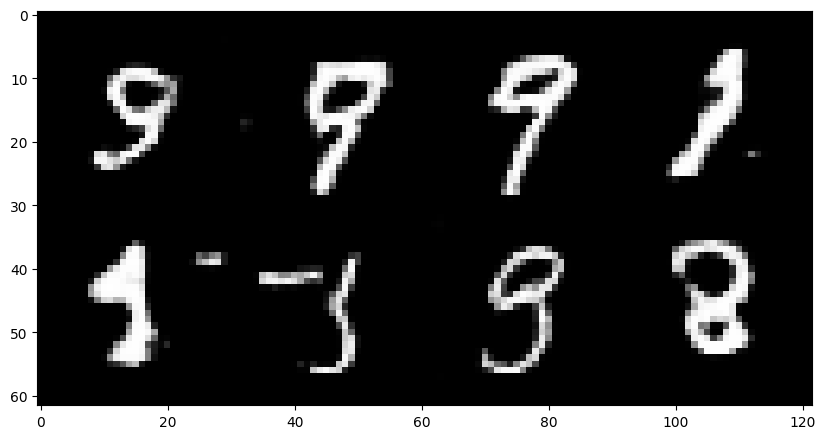

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.5377] [G loss: 3.3353]


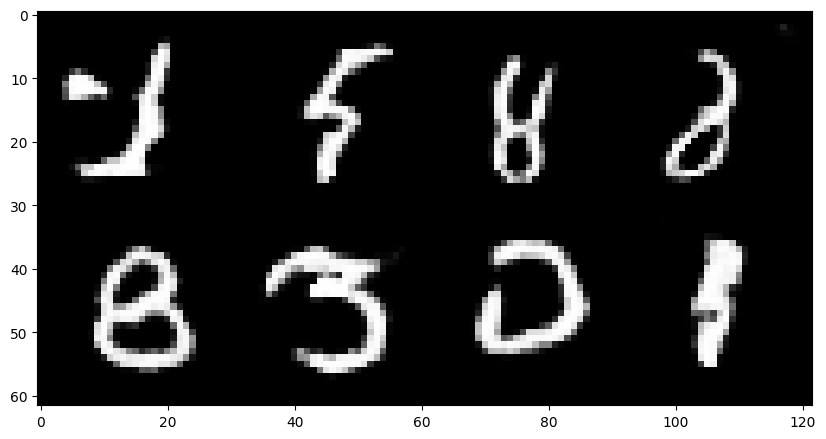

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.4078] [G loss: 2.6208]


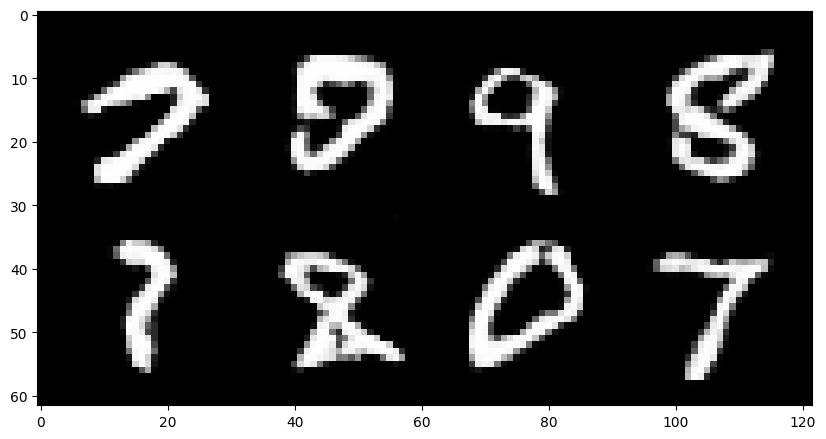

In [14]:
generator, discriminator, val_gen_losses, val_dis_losses = train_gan(train_loader, val_loader, latent_dim, num_epochs=20)

In [15]:
torch.save(generator.state_dict(), data_path+'gen_model.pth')
torch.save(discriminator.state_dict(), data_path+'dis_model.pth')

# Compare

Use validation dataset to plot and compare the results of your trained models.

In [19]:
# TODO
# Comparison of the generated images

In [18]:
def plot(losses, title):
  plt.plot(np.arange(len(losses)), losses)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(title)
  plt.show()

## **VAE**

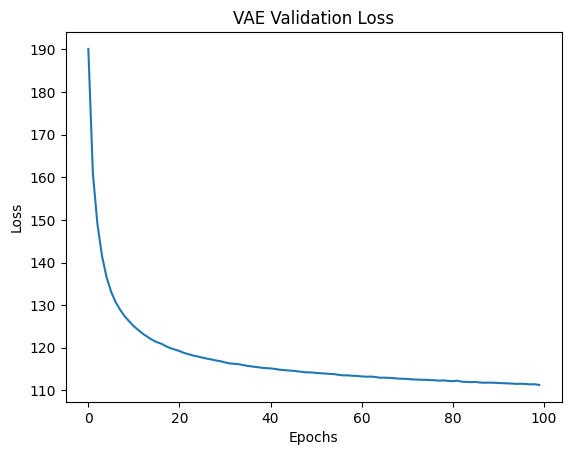

In [20]:
# VAE validation loss plot
plot(losses=vae_val_loss, title='VAE Validation Loss')

In [35]:
vae = VAE(784, 256, 10)
vae.load_state_dict(torch.load(data_path+'vae_model.pth'))
vae.to(DEVICE)
vae.eval()

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=256, bias=True)
    (fc_mean): Linear(in_features=256, out_features=10, bias=True)
    (fc_log_var): Linear(in_features=256, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=10, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=784, bias=True)
  )
)

In [36]:
def VAElatentSamplegeneration(model, num=64):
  model.eval()
  with torch.no_grad():
    x = torch.randn(num, 10).to(DEVICE)
    samples = model.decoder(x).cpu()
    samples = samples.view(num, 1, 28, 28)
    grid_img = torchvision.utils.make_grid(samples, nrow=num//8, padding=2, normalize=True)
    plt.figure(figsize=(15, 15))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

  return samples

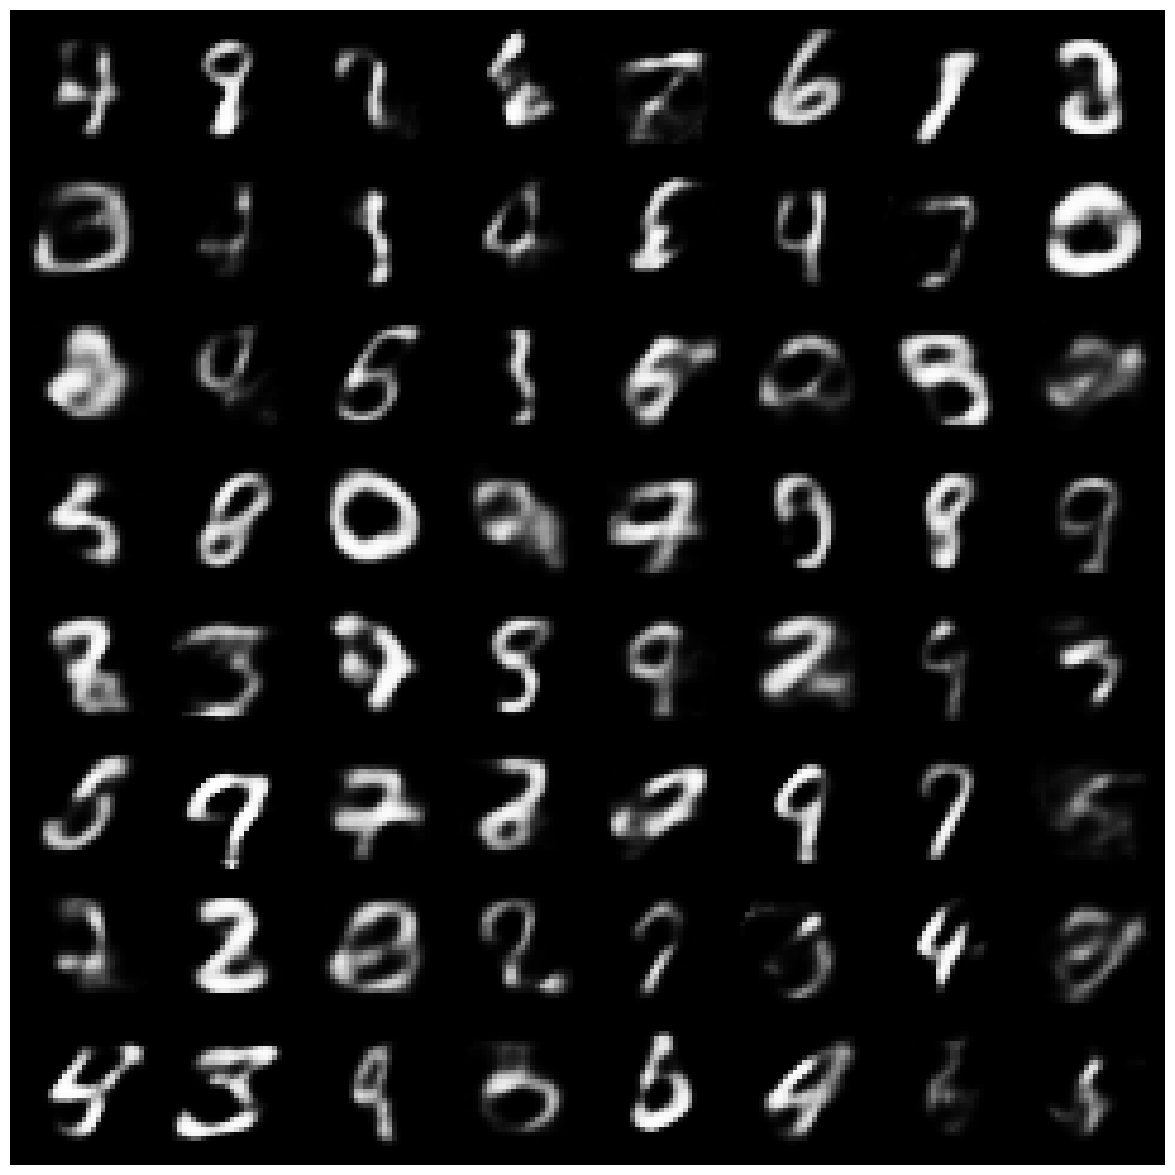

tensor([[[[4.3309e-17, 1.1732e-16, 1.3943e-16,  ..., 6.6971e-17,
           7.4800e-17, 3.3937e-17],
          [1.0130e-16, 6.9574e-17, 8.1738e-17,  ..., 4.0370e-17,
           3.5909e-17, 6.7590e-17],
          [9.0705e-17, 2.3958e-17, 1.0575e-32,  ..., 1.0477e-30,
           3.0880e-16, 2.8743e-17],
          ...,
          [8.9964e-17, 5.7681e-17, 1.7367e-15,  ..., 5.1341e-14,
           1.9563e-25, 7.8711e-17],
          [6.1145e-17, 2.3646e-16, 4.7627e-17,  ..., 9.3851e-39,
           5.8325e-17, 6.6200e-17],
          [7.7422e-17, 2.7460e-17, 7.7572e-17,  ..., 2.9836e-17,
           3.9032e-17, 3.3751e-17]]],


        [[[4.2469e-21, 8.4555e-21, 7.6802e-21,  ..., 4.9534e-21,
           3.3732e-21, 1.9920e-20],
          [6.0028e-21, 9.7348e-21, 7.4420e-21,  ..., 2.9025e-20,
           1.1510e-21, 2.9892e-21],
          [1.3919e-20, 8.2753e-21, 0.0000e+00,  ..., 0.0000e+00,
           3.0212e-21, 4.1331e-21],
          ...,
          [3.5261e-21, 1.2793e-20, 4.4600e-21,  ..., 4.53

In [37]:
VAElatentSamplegeneration(vae)

## **GAN**

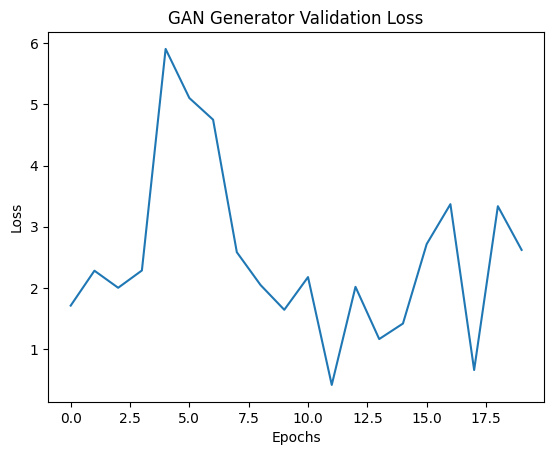

In [24]:
# GAN Generator validation loss plot
plot(losses=val_gen_losses, title='GAN Generator Validation Loss')

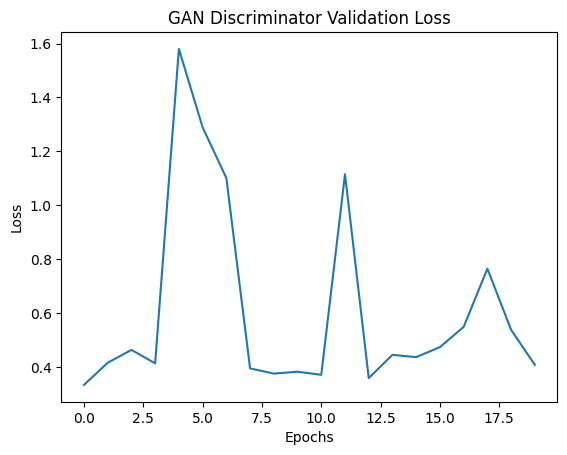

In [25]:
# GAN Discriminator validation loss plot
plot(losses=val_dis_losses, title='GAN Discriminator Validation Loss')

In [38]:
generator = Generator(latent_dim=100, img_shape=(1, 28, 28))
generator.load_state_dict(torch.load(data_path+'gen_model.pth'))
generator.to(DEVICE)
generator.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
    (1): ReLU(inplace=True)
    (2): Unflatten(dim=1, unflattened_size=(128, 7, 7))
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Sigmoid()
  )
)

In [39]:
def GANlatentSamplegeneration(model, num=64):
  model.eval()
  with torch.no_grad():
    x = torch.randn(num, 100).to(DEVICE)
    samples = model(x).cpu()
    samples = samples.view(num, 1, 28, 28)
    grid_img = torchvision.utils.make_grid(samples, nrow=num//8, padding=2, normalize=True)
    plt.figure(figsize=(15, 15))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

  return samples

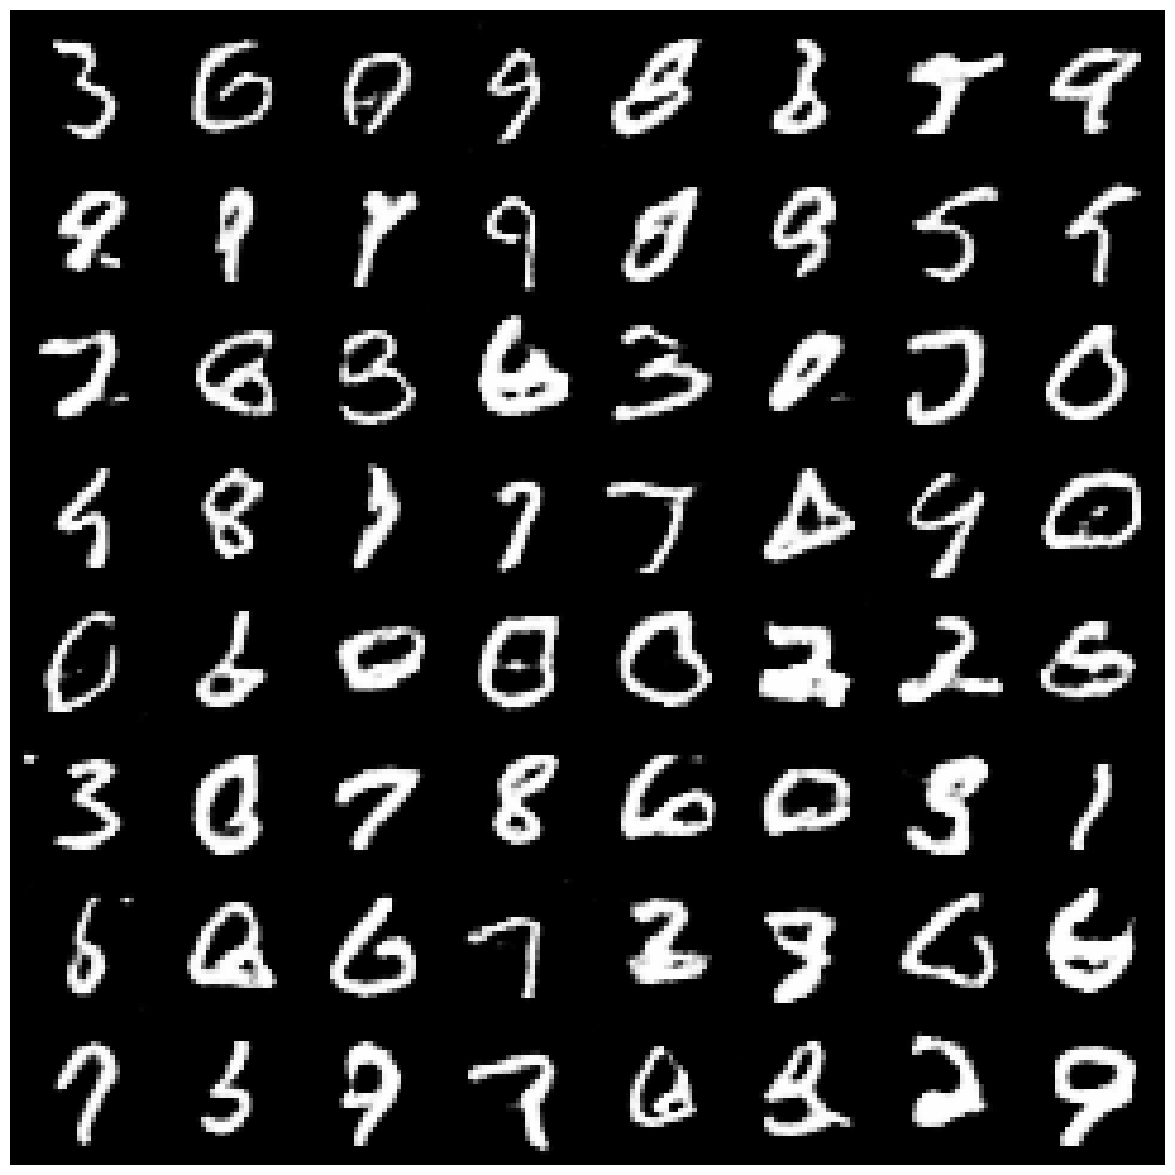

tensor([[[[4.4120e-07, 1.4209e-09, 3.8680e-09,  ..., 1.4391e-08,
           3.0846e-08, 3.7452e-06],
          [1.7351e-09, 7.2275e-13, 1.0289e-11,  ..., 7.0026e-13,
           1.1437e-11, 2.9003e-08],
          [6.1221e-09, 1.0492e-11, 6.3927e-11,  ..., 4.6497e-11,
           1.8159e-10, 4.2369e-07],
          ...,
          [7.5668e-05, 1.4113e-06, 1.0227e-08,  ..., 3.9545e-07,
           3.0096e-04, 2.6523e-03],
          [1.7163e-05, 2.9602e-06, 5.6858e-08,  ..., 2.5370e-05,
           1.6948e-03, 4.7543e-04],
          [1.2542e-04, 3.8354e-05, 4.8776e-06,  ..., 3.3424e-04,
           8.5047e-04, 3.5157e-04]]],


        [[[7.2972e-05, 1.6060e-04, 3.8497e-06,  ..., 2.9214e-09,
           6.7172e-09, 2.1790e-06],
          [6.0151e-05, 9.6348e-06, 2.2259e-07,  ..., 3.7079e-14,
           1.6908e-12, 8.1841e-09],
          [7.9083e-05, 1.0076e-05, 1.2627e-07,  ..., 9.0939e-14,
           1.6679e-13, 1.0414e-09],
          ...,
          [8.2246e-06, 6.3960e-06, 1.4433e-06,  ..., 1.41

In [40]:
GANlatentSamplegeneration(generator, num=64)

## Evaluate with GAN discriminator

In [30]:
# load discriminator
discriminator = Discriminator(img_dim=(1, 28, 28))
discriminator.load_state_dict(torch.load(data_path+'dis_model.pth'))

<All keys matched successfully>

In [31]:
def discriminatorEvaluation(model, generated_samples):
  model.eval()
  pred_validation = model(generated_samples)

  pred_validation[pred_validation >= 0.5] = 1
  pred_validation[pred_validation < 0.5] = 0

  return np.count_nonzero(pred_validation == 1) / pred_validation.shape[0]

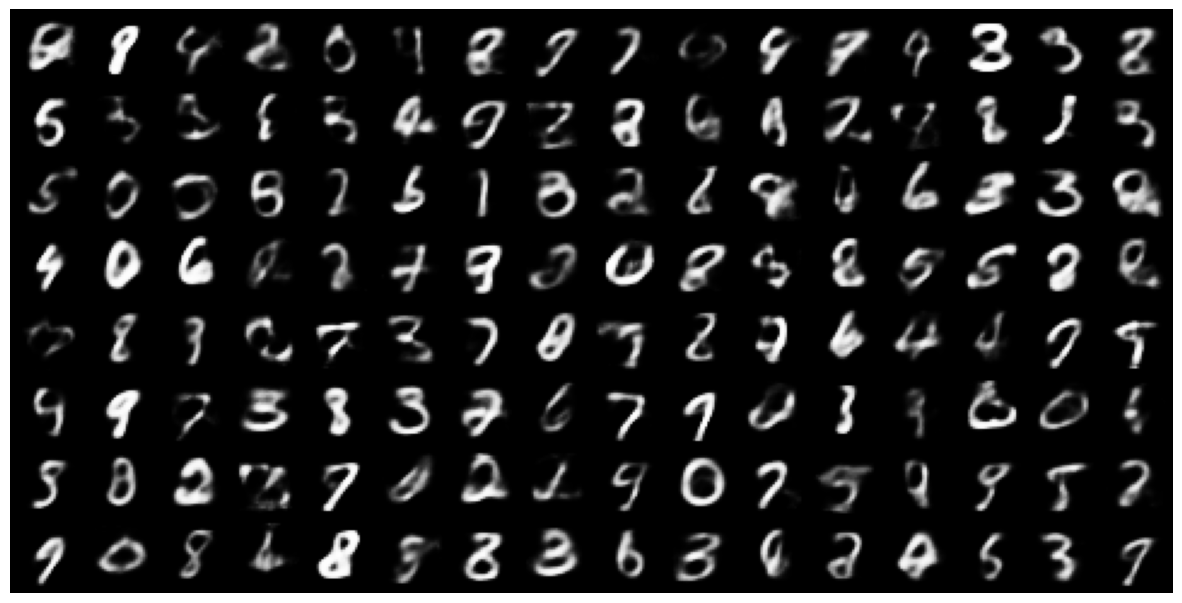

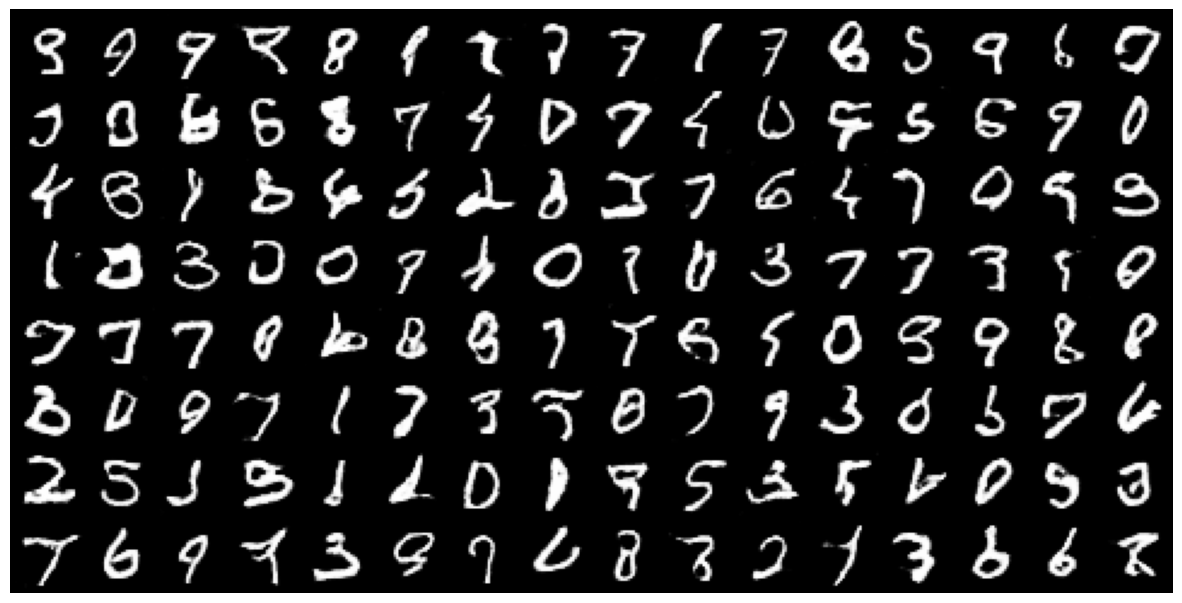

In [32]:
vae_generated_samples = VAElatentSamplegeneration(vae.to('cuda'), num=128)
gan_generated_samples = GANlatentSamplegeneration(generator.to('cuda'), num=128)

In [33]:
vae_generated_samples.shape, gan_generated_samples.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128, 1, 28, 28]))

In [34]:
print(f'percentage of valid generated image to all for GAN model: {discriminatorEvaluation(discriminator, gan_generated_samples)}')
print(f'percentage of valid generated image to all for VAE model: {discriminatorEvaluation(discriminator, vae_generated_samples)}')

percentage of valid generated image to all for GAN model: 0.0390625
percentage of valid generated image to all for VAE model: 0.0078125
